# Imports:

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats.stats import pearsonr, ttest_ind
from os.path import join, sep
import config as c
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

# Set some important variables:

In [3]:
valid_users = c.valid_users
watch_acc_base = c.watch_acc_baseline
phone_acc_base = c.phone_acc_baseline
statistics = ['median', 'mean', np.std]
min_val = c.report_values[0]
max_val = c.report_values[-1]

# Set working environment:

In [4]:
cloud = False
if cloud:
    data_path = c.cloud_data_path
else:
    data_path = c.data_path

# Read Data:

In [5]:
clinic_assessments_watch_acc_df = pd.read_pickle(c.clinic_assessments_watch_acc_pkl_file_path)
clinic_assessments_watch_acc_df.name = 'clinic_assessments_watch_acc'

clinic_steps_watch_acc_df = pd.read_pickle(c.clinic_steps_watch_acc_pkl_file_path)
clinic_steps_watch_acc_df.name = 'clinic_steps_watch_acc'

home_assessments_watch_acc_df = pd.read_pickle(c.home_assessments_watch_acc_pkl_file_path)
home_assessments_watch_acc_df.name = 'home_assessments_watch_acc'

home_steps_watch_acc_df = pd.read_pickle(c.home_steps_watch_acc_pkl_file_path)
home_steps_watch_acc_df.name = 'home_steps_watch_acc'

home_reminders_watch_acc_df = pd.read_pickle(c.home_reminders_watch_acc_pkl_file_path)
home_reminders_watch_acc_df.name = 'home_reminders_watch_acc'

clinic_steps_phone_acc_df = pd.read_pickle(c.clinic_steps_phone_acc_pkl_file_path)
clinic_steps_phone_acc_df.name = 'clinic_steps_phone_acc'

home_steps_phone_acc_df = pd.read_pickle(c.home_steps_phone_acc_pkl_file_path)
home_steps_phone_acc_df.name = 'home_steps_phone_acc'

In [6]:
def trim_sensor_data(df, trim_resolution, trim_size, parent_resolution=None, trim_start=True, trim_end=True):
    if trim_start:
        trim_start = trim_size
    else:
        trim_start = 0
    if trim_end:
        trim_end = -trim_size
    else:
        trim_end = df.shape[0]
    trimmed_df = pd.DataFrame()
    if parent_resolution:
        parents_list = df[parent_resolution].unique().tolist()
        for parent in parents_list:
            parent_df = df[df[parent_resolution]==parent]
            sons_list = parent_df[trim_resolution].unique().tolist()
            for son in sons_list:
                son_df = parent_df[parent_df[trim_resolution]==son]
                son_slice = son_df.iloc[trim_start:trim_end]
                trimmed_df = pd.concat([trimmed_df, son_slice])
    else:
        sons_list = df[trim_resolution].unique().tolist()
        for son in sons_list:
            son_df = df[df[trim_resolution]==son]
            son_slice = son_df.iloc[trim_start:trim_end]
            trimmed_df = pd.concat([trimmed_df, son_slice])
    return trimmed_df

## Check which users appear in which datasets:

In [5]:
print(sorted(clinic_assessments_watch_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(clinic_steps_watch_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(home_assessments_watch_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(home_steps_watch_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(home_reminders_watch_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(clinic_steps_phone_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(home_steps_phone_acc_df.user_id.unique().astype(int).tolist()))

[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]


 # Define summary function:

In [12]:
def plot_statistics_distribution(df, assessment_id, user_id, target_variable,
                                 statistics, with_median = False,
                                 min_val=min_val, max_val=max_val, bars_gap=0.5):
    
    # Show the number of assessments per user in the given dataset:
    print('\nNumber of assessments per user in this dataset:')
    print(df[[user_id, assessment_id]].groupby(user_id)[assessment_id].nunique(), '\n')
    
    # Aggregate (mean) the reported target variable per assessment: 
    grouped_reports = df[[assessment_id, user_id, target_variable]].groupby(assessment_id, as_index=False).agg('mean')
    reports = grouped_reports[target_variable].astype(int)
    
    # Count report appearances for each possible value (even if didn't appear):
    counts = []
    for x in c.report_values:
        x_count = len([r for r in reports if r==x])
        counts.append(x_count)
    
    # Plot the reported values distribution across all assessments:
    fig, ax = plt.subplots()
    ax.bar(c.report_values, counts, width=0.4, align='center')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title('%s distribution across all records in %s' % (target_variable, df.name))
    ax.set_xlabel('Reported Chorea')
    ax.set_ylabel('Count')
    plt.show()

    
    # Aggregate (mean, std, median) all assessments per patient:
    print('\n')
    per_user_stats = grouped_reports[[user_id, target_variable]].groupby(user_id, as_index=False).agg(statistics)
    per_user_stats.columns = per_user_stats.columns.droplevel(0)
    per_user_stats.reset_index(inplace=True)
    
    means = per_user_stats['mean']
    stds = per_user_stats['std']
    if with_median:
        medians = per_user_stats['median']
    users = per_user_stats['user_id'].astype(str)
    n_users = users.shape[0]
    users_enum = range(1, n_users+1)
    
    # Bar plot - mean + error bars (optional: median)
    width = 0.3
    fig = plt.figure(2)
    ax = fig.add_subplot(111)

    rects1 = ax.bar(users_enum, means, width, color='g', yerr=stds)
    if with_median:
        rects2 = ax.bar(users_enum+width, medians, width, color='b')
    
    ax.set_title('Summary statistics per patient in %s' %(df.name))
    ax.set_xlabel('Patient ID')
    if with_median:
        ax.set_ylabel('Reported Chorea')
        ax.set_xticks(users_enum+(0.5*width))
        ax.legend((rects1[0], rects2[0]), ('Mean', 'Median'))
    else:
        ax.set_ylabel('Mean Reported Chorea')
        ax.set_xticks(users_enum)    
    ax.set_xticklabels(users)
    plt.show()
    
    # Plot per-patient mean reported value (as dots) + error bars:
    plt.xticks(users_enum, users)
    plt.errorbar(users_enum, means, stds, color='b', fmt='.', markersize='10',
                 ecolor='r',capsize=4, elinewidth=2, linestyle='None')
    plt.ylim(min_val-bars_gap, max_val+bars_gap)
    plt.title('Mean Report Chorea $\pm$ Standard Deviation, Per Patient')
    plt.xlabel('Patient ID')
    plt.ylabel('Mean Reported Chorea')
    plt.show()
    
    # Calculate the fraction of 'positive' reports per patient, and plot:
    print('\n')
    grouped_reports['binary_report'] = grouped_reports[target_variable]>=1
    binary_avg = grouped_reports[[user_id, 'binary_report']].groupby(user_id, as_index=False).agg('mean')
    binary_avg['user_id'] = binary_avg['user_id'].astype(str)

    plt.figure(4)
    plt.bar(users_enum, binary_avg['binary_report'])
    plt.xticks(users_enum, binary_avg['user_id'])
    plt.title('Fraction of positive (>0) reports per patient in %s' %(df.name))
    plt.xlabel('Patient ID')
    plt.ylabel('Fraction of positive reports')
    plt.show()
    
    return

## Present reports from the lab, per assessment:

In [7]:
clinic_assessments_watch_acc_df[['user_id', 'assessment_id', 'patient_report_value', 'clinician_report_value']].\
groupby(['user_id', 'assessment_id'], as_index=False).agg('mean').head(15)

,user_id,assessment_id,patient_report_value,clinician_report_value
0,8,1490640580656,1.0,2.0
1,25,1487605701264,1.0,2.0
2,25,1493912424448,0.0,2.0
3,45,1490637319938,2.0,3.0
4,51,1490284781631,3.0,2.0
5,57,1481923232988,1.0,2.0
6,63,1493920652116,0.0,2.0
7,74,1485546321147,2.0,2.0
8,82,1489765988342,3.0,4.0
9,94,1493741957038,3.0,2.0


## Inspect patients' reports for lab assessments:


Number of assessments per user in this dataset:
user_id
8      1
25     2
45     1
51     1
57     1
63     1
74     1
82     1
94     1
108    1
Name: assessment_id, dtype: int64 



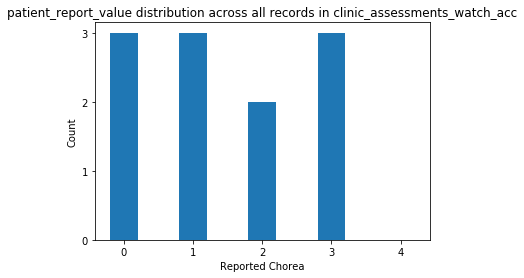

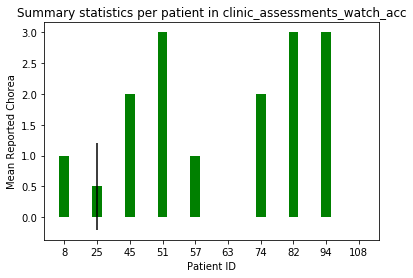

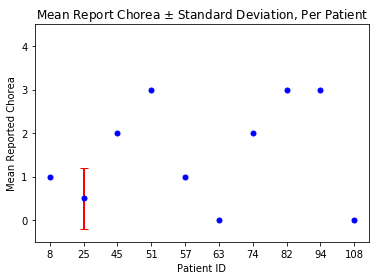

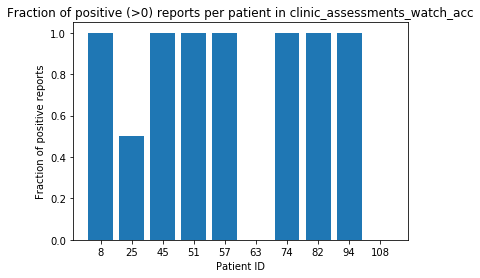

In [13]:
plot_statistics_distribution(clinic_assessments_watch_acc_df, assessment_id='assessment_id',
                             user_id ='user_id',
                             target_variable='patient_report_value', statistics=statistics)

## Inspect clinicians' reports for lab assessments:


Number of assessments per user in this dataset:
user_id
8      1
25     2
45     1
51     1
57     1
63     1
74     1
82     1
94     1
108    1
Name: assessment_id, dtype: int64 



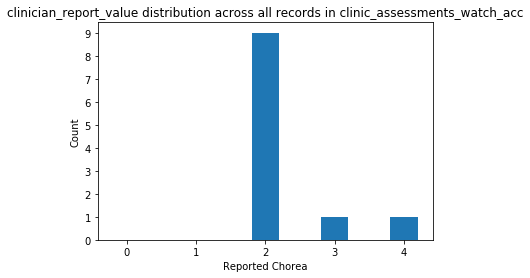

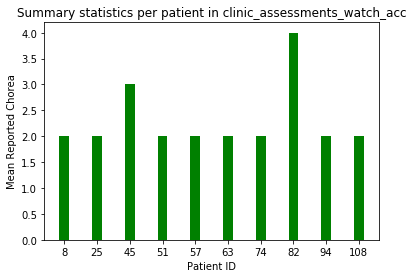

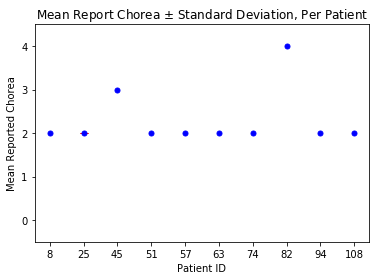

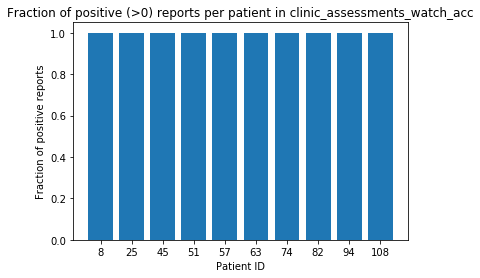

In [14]:
plot_statistics_distribution(clinic_assessments_watch_acc_df, assessment_id='assessment_id',
                             user_id ='user_id',
                             target_variable='clinician_report_value', statistics=statistics)

## Inspect patients' reports for home assessments:


Number of assessments per user in this dataset:
user_id
8       25
25      30
45      56
51      65
57      99
63      12
74     134
82      34
94       8
108     37
Name: assessment_id, dtype: int64 



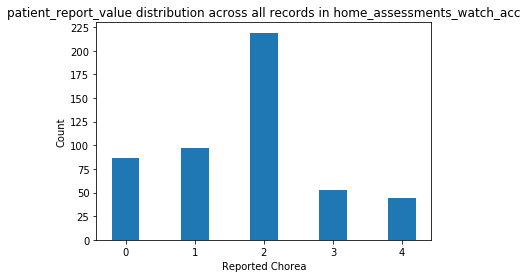

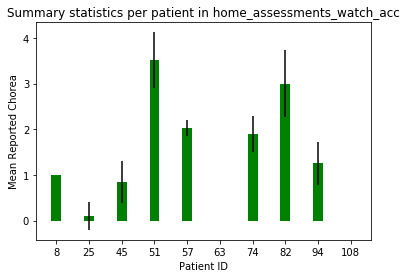

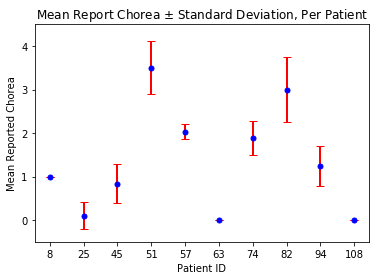

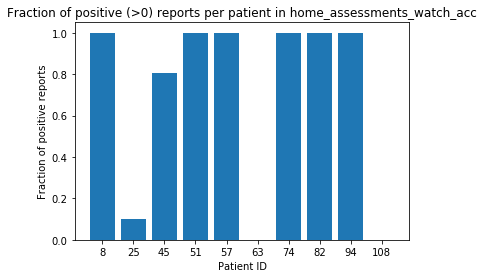

In [15]:
plot_statistics_distribution(home_assessments_watch_acc_df, assessment_id='assessment_id',
                             user_id ='user_id',
                             target_variable='patient_report_value', statistics=statistics)

## Inspect patients' reports for pre-reminder 5-minutes segments:


Number of assessments per user in this dataset:
user_id
8       48
45       6
51      35
57     305
63      28
74     204
82      73
94      18
108     78
Name: reminder_id, dtype: int64 



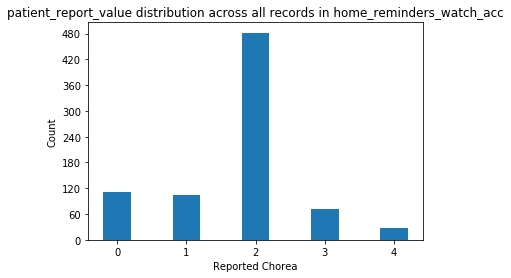

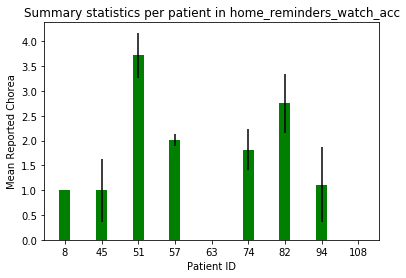

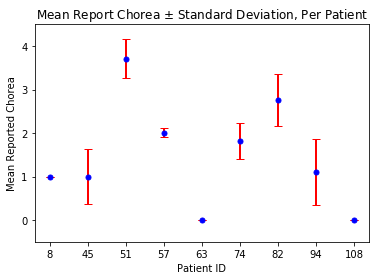

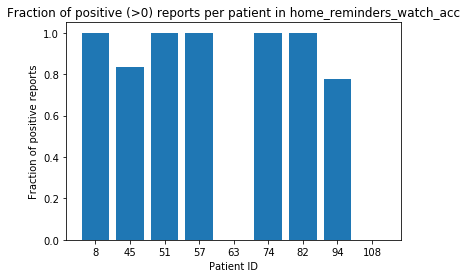

In [16]:
plot_statistics_distribution(home_reminders_watch_acc_df, assessment_id='reminder_id',
                             user_id ='user_id',
                             target_variable='patient_report_value', statistics=statistics)

## Lab data: patients' reports vs. clinicians' reports:

    assessment_id  patient_report_value  clinician_report_value
0   1481923232988                   1.0                     2.0
1   1485546321147                   2.0                     2.0
2   1487605701264                   1.0                     2.0
3   1488396181636                   0.0                     2.0
4   1489765988342                   3.0                     4.0
5   1490284781631                   3.0                     2.0
6   1490637319938                   2.0                     3.0
7   1490640580656                   1.0                     2.0
8   1493741957038                   3.0                     2.0
9   1493912424448                   0.0                     2.0
10  1493920652116                   0.0                     2.0

Correlation of: 0.463 
p-value of: 0.151


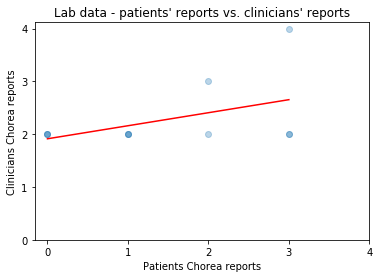

In [12]:
report_per_assess = clinic_assessments_watch_acc_df[['assessment_id', 'patient_report_value', 'clinician_report_value']]\
                    .groupby('assessment_id', as_index=False).agg('mean')
print(report_per_assess.head(15))
patients = report_per_assess.patient_report_value
clinicians = report_per_assess.clinician_report_value

coef, p_val = pearsonr(patients, clinicians)
print('\n' 'Correlation of: %.3f \np-value of: %.3f' % (coef, p_val))

plt.scatter(patients, clinicians, alpha=0.3)
plt.plot(np.unique(patients),
         np.poly1d(np.polyfit(patients, clinicians, 1))(np.unique(patients)),
         color='r')
plt.xticks(c.report_values)
plt.yticks(c.report_values)
plt.xlabel('Patients Chorea reports')
plt.ylabel('Clinicians Chorea reports')
plt.title("Lab data - patients' reports vs. clinicians' reports")
plt.show()

## Patients' lab assessments reports vs. their (mean) home assessments reports:

   user_id  clinic_mean_report  home_mean_report
0        8            1.000000          1.000000
1       25            0.471868          0.024907
2       45            2.000000          0.854098
3       51            3.000000          3.378679
4       57            1.000000          2.045206
5       63            0.000000          0.000000
6       74            2.000000          1.892135
7       82            3.000000          3.050616
8       94            3.000000          1.015119
9      108            0.000000          0.000000

Correlation of: 0.769 
p-value of: 0.009


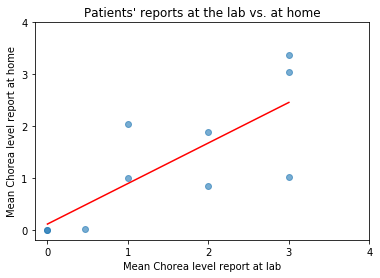

In [13]:
clinic_report_per_user = clinic_assessments_watch_acc_df[['user_id', 'patient_report_value']].groupby('user_id').agg('mean')
clinic_report_per_user.columns = ['clinic_mean_report']
clinic_report_per_user.sort_index(inplace=True)

home_report_per_user = home_assessments_watch_acc_df[['user_id', 'patient_report_value']].groupby('user_id').agg('mean')
home_report_per_user.columns = ['home_mean_report']
home_report_per_user.sort_index(inplace=True)

both_reports = pd.concat([clinic_report_per_user, home_report_per_user], axis=1)
both_reports.dropna(inplace=True)
both_reports.reset_index(inplace=True)
print(both_reports.head(15))

clinic_mean = both_reports.clinic_mean_report
home_mean = both_reports.home_mean_report

coef, p_val = pearsonr(clinic_mean, home_mean)
print('\n' 'Correlation of: %.3f \np-value of: %.3f' % (coef, p_val))

plt.scatter(clinic_mean, home_mean, alpha=0.6)
plt.plot(np.unique(clinic_mean),
         np.poly1d(np.polyfit(clinic_mean, home_mean, 1))(np.unique(clinic_mean)),
         color='r')
plt.xticks(c.report_values)
plt.yticks(c.report_values)
plt.xlabel('Mean Chorea level report at lab')
plt.ylabel('Mean Chorea level report at home')
plt.title("Patients' reports at the lab vs. at home")
plt.show()

## Clinicians' lab assessments reports vs. patients' (mean) home assessments reports:

   user_id  clinic_mean_report  home_mean_report
0        8                 2.0          1.000000
1       25                 2.0          0.024907
2       45                 3.0          0.854098
3       51                 2.0          3.378679
4       57                 2.0          2.045206
5       63                 2.0          0.000000
6       74                 2.0          1.892135
7       82                 4.0          3.050616
8       94                 2.0          1.015119
9      108                 2.0          0.000000

Correlation of: 0.398 
p-value of: 0.255


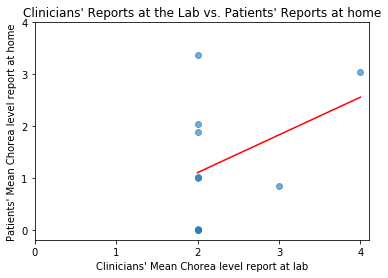

In [14]:
clinic_report_per_user = clinic_assessments_watch_acc_df[['user_id', 'clinician_report_value']].groupby('user_id').agg('mean')
clinic_report_per_user.columns = ['clinic_mean_report']
clinic_report_per_user.sort_index(inplace=True)

home_report_per_user = home_assessments_watch_acc_df[['user_id', 'patient_report_value']].groupby('user_id').agg('mean')
home_report_per_user.columns = ['home_mean_report']
home_report_per_user.sort_index(inplace=True)

both_reports = pd.concat([clinic_report_per_user, home_report_per_user], axis=1)
both_reports.dropna(inplace=True)
both_reports.reset_index(inplace=True)
print(both_reports.head(15))

clinic_mean = both_reports.clinic_mean_report
home_mean = both_reports.home_mean_report

coef, p_val = pearsonr(clinic_mean, home_mean)
print('\n' 'Correlation of: %.3f \np-value of: %.3f' % (coef, p_val))

plt.scatter(clinic_mean, home_mean, alpha=0.6)
plt.plot(np.unique(clinic_mean),
         np.poly1d(np.polyfit(clinic_mean, home_mean, 1))(np.unique(clinic_mean)),
         color='r')
plt.xticks(range(5))
plt.yticks(range(5))
plt.xlabel("Clinicians' Mean Chorea level report at lab")
plt.ylabel("Patients' Mean Chorea level report at home")
plt.title("Clinicians' Reports at the Lab vs. Patients' Reports at home")
plt.show()

## Patients' mean home pre-reminders reports vs. their mean home assessments reports:

         assessments_mean_report_value  reminders_mean_report_value
user_id                                                            
8                             1.000000                     1.000000
45                            0.839286                     1.000000
51                            3.507692                     3.714286
57                            2.030303                     2.013115
63                            0.000000                     0.000000
74                            1.895522                     1.813725
82                            3.000000                     2.753425
94                            1.250000                     1.111111
108                           0.000000                     0.000000

Correlation of: 0.994 
p-value of: 0.000


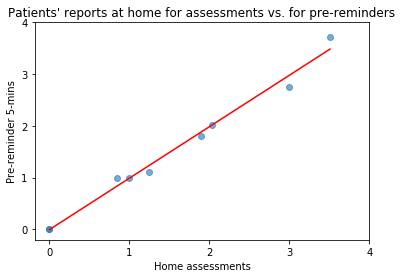

In [15]:
home_unique_assessments = home_assessments_watch_acc_df[['user_id', 'assessment_id', 'patient_report_value']]\
.groupby(['user_id', 'assessment_id'], as_index=False).agg('mean')
home_assess_patient_avg = home_unique_assessments[['user_id', 'patient_report_value']].groupby('user_id').agg('mean')
home_assess_patient_avg.columns = ['assessments_mean_report_value']
home_assess_patient_avg.sort_index(inplace=True)

home_unique_reminders = home_reminders_watch_acc_df[['user_id', 'reminder_id', 'patient_report_value']]\
.groupby(['user_id', 'reminder_id'], as_index=False).agg('mean')
home_remind_patient_avg = home_unique_reminders[['user_id', 'patient_report_value']].groupby('user_id').agg('mean')
home_remind_patient_avg.columns = ['reminders_mean_report_value']
home_remind_patient_avg.sort_index(inplace=True)

both_home = pd.concat([home_assess_patient_avg, home_remind_patient_avg], axis=1)
both_home.dropna(inplace=True)
print(both_home.head(15))

assess_mean = both_home.assessments_mean_report_value
remind_mean = both_home.reminders_mean_report_value

coef, p_val = pearsonr(assess_mean, remind_mean)
print('\n' 'Correlation of: %.3f \np-value of: %.3f' % (coef, p_val))

plt.scatter(assess_mean, remind_mean, alpha=0.6)
plt.plot(np.unique(assess_mean),
         np.poly1d(np.polyfit(assess_mean, remind_mean, 1))(np.unique(assess_mean)),
         color='r')
plt.xticks(range(5))
plt.yticks(range(5))
plt.xlabel('Home assessments')
plt.ylabel('Pre-reminder 5-mins')
plt.title("Patients' reports at home for assessments vs. for pre-reminders")
plt.show()

# Raw accelerometer data analysis:

In [7]:
clinic_steps_watch_acc_df['acc_norm'] = np.sqrt((clinic_steps_watch_acc_df.x)**2 +\
                                                (clinic_steps_watch_acc_df.y)**2 +\
                                                (clinic_steps_watch_acc_df.z)**2)
clinic_steps_watch_acc_df['acc_abs_delta'] = abs(clinic_steps_watch_acc_df['acc_norm']-watch_acc_base)


home_steps_watch_acc_df['acc_norm'] = np.sqrt((home_steps_watch_acc_df.x)**2 +\
                                              (home_steps_watch_acc_df.y)**2 +\
                                              (home_steps_watch_acc_df.z)**2)
home_steps_watch_acc_df['acc_abs_delta'] = abs(home_steps_watch_acc_df['acc_norm']-watch_acc_base)


home_reminders_watch_acc_df['acc_norm'] = np.sqrt((home_reminders_watch_acc_df.x)**2 +\
                                                  (home_reminders_watch_acc_df.y)**2 +\
                                                  (home_reminders_watch_acc_df.z)**2)
home_reminders_watch_acc_df['acc_abs_delta'] = abs(home_reminders_watch_acc_df['acc_norm']-watch_acc_base)


clinic_steps_phone_acc_df['acc_norm'] = np.sqrt((clinic_steps_phone_acc_df.x)**2 +\
                                                (clinic_steps_phone_acc_df.y)**2 +\
                                                (clinic_steps_phone_acc_df.z)**2)
clinic_steps_phone_acc_df['acc_abs_delta'] = abs(clinic_steps_phone_acc_df['acc_norm']-phone_acc_base)


home_steps_phone_acc_df['acc_norm'] = np.sqrt((home_steps_phone_acc_df.x)**2 +\
                                              (home_steps_phone_acc_df.y)**2 +\
                                              (home_steps_phone_acc_df.z)**2)
home_steps_phone_acc_df['acc_abs_delta'] = abs(home_steps_phone_acc_df['acc_norm']-phone_acc_base)

In [8]:
trimmed_clinic_steps_watch_acc = trim_sensor_data(clinic_steps_watch_acc_df, 'step_name', 200, 'assessment_id')
trimmed_clinic_steps_watch_acc.name = 'trimmed_clinic_steps_watch_acc'

trimmed_clinic_steps_phone_acc = trim_sensor_data(clinic_steps_phone_acc_df, 'step_name', 200, 'assessment_id')
trimmed_clinic_steps_phone_acc.name = 'trimmed_clinic_steps_phone_acc'

trimmed_home_steps_watch_acc = trim_sensor_data(home_steps_watch_acc_df, 'step_name', 200, 'assessment_id')
trimmed_home_steps_watch_acc.name = 'trimmed_home_steps_watch_acc'

trimmed_home_steps_phone_acc = trim_sensor_data(home_steps_phone_acc_df, 'step_name', 200, 'assessment_id')
trimmed_home_steps_phone_acc.name = 'trimmed_home_steps_phone_acc'

In [9]:
clinic_steps_phone_acc_df.step_name.unique()

array(['TUaG', 'Sit extended', 'Stand', 'Sit relaxed', 'Rotate hands',
       'Drink', 'Walk'], dtype=object)

In [19]:
clinic_watch_per_patient_step_mean_norm = clinic_steps_watch_acc_df[['user_id', 'step_name', 'acc_norm']]\
                                          .groupby(['user_id', 'step_name'], as_index=False).agg('mean')
clinic_steps_watch_acc_w_base = clinic_steps_watch_acc_df.merge(right=clinic_watch_per_patient_step_mean_norm,
                                                                how='inner',
                                                                on=['user_id', 'step_name'],
                                                                suffixes=['', '_mean'])
clinic_steps_watch_acc_w_base.name = 'clinic_steps_watch_acc_with_user_baseline'
clinic_steps_watch_acc_w_base['acc_abs_delta_user_bl'] = abs(clinic_steps_watch_acc_w_base['acc_norm']-\
                                                             clinic_steps_watch_acc_w_base['acc_norm_mean'])


trimmed_clinic_watch_per_patient_step_mean_norm = trimmed_clinic_steps_watch_acc[['user_id', 'step_name', 'acc_norm']]\
                                                  .groupby(['user_id', 'step_name'], as_index=False).agg('mean')
trimmed_clinic_steps_watch_acc_w_base = trimmed_clinic_steps_watch_acc.merge(right=trimmed_clinic_watch_per_patient_step_mean_norm,
                                                                             how='inner',
                                                                             on=['user_id', 'step_name'],
                                                                             suffixes=['', '_mean'])
trimmed_clinic_steps_watch_acc_w_base.name = 'trimmed_clinic_steps_watch_acc_with_user_baseline'
trimmed_clinic_steps_watch_acc_w_base['acc_abs_delta_user_bl'] = abs(trimmed_clinic_steps_watch_acc_w_base['acc_norm']-\
                                                             trimmed_clinic_steps_watch_acc_w_base['acc_norm_mean'])


home_watch_per_patient_step_mean_norm = home_steps_watch_acc_df[['user_id', 'step_name', 'acc_norm']]\
                                        .groupby(['user_id', 'step_name'], as_index=False).agg('mean')
home_steps_watch_acc_w_base = home_steps_watch_acc_df.merge(right=home_watch_per_patient_step_mean_norm,
                                                            how='inner',
                                                            on=['user_id', 'step_name'],
                                                            suffixes=['', '_mean'])
home_steps_watch_acc_w_base.name = 'home_steps_watch_acc_with_user_baseline'
home_steps_watch_acc_w_base['acc_abs_delta_user_bl'] = abs(home_steps_watch_acc_w_base['acc_norm']-\
                                                           home_steps_watch_acc_w_base['acc_norm_mean'])


trimmed_home_watch_per_patient_step_mean_norm = trimmed_home_steps_watch_acc[['user_id', 'step_name', 'acc_norm']]\
                                                  .groupby(['user_id', 'step_name'], as_index=False).agg('mean')
trimmed_home_steps_watch_acc_w_base = trimmed_home_steps_watch_acc.merge(right=trimmed_home_watch_per_patient_step_mean_norm,
                                                                             how='inner',
                                                                             on=['user_id', 'step_name'],
                                                                             suffixes=['', '_mean'])
trimmed_home_steps_watch_acc_w_base.name = 'trimmed_home_steps_watch_acc_with_user_baseline'
trimmed_home_steps_watch_acc_w_base['acc_abs_delta_user_bl'] = abs(trimmed_home_steps_watch_acc_w_base['acc_norm']-\
                                                             trimmed_home_steps_watch_acc_w_base['acc_norm_mean'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025502BC7A20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000025506FADF28>]], dtype=object)

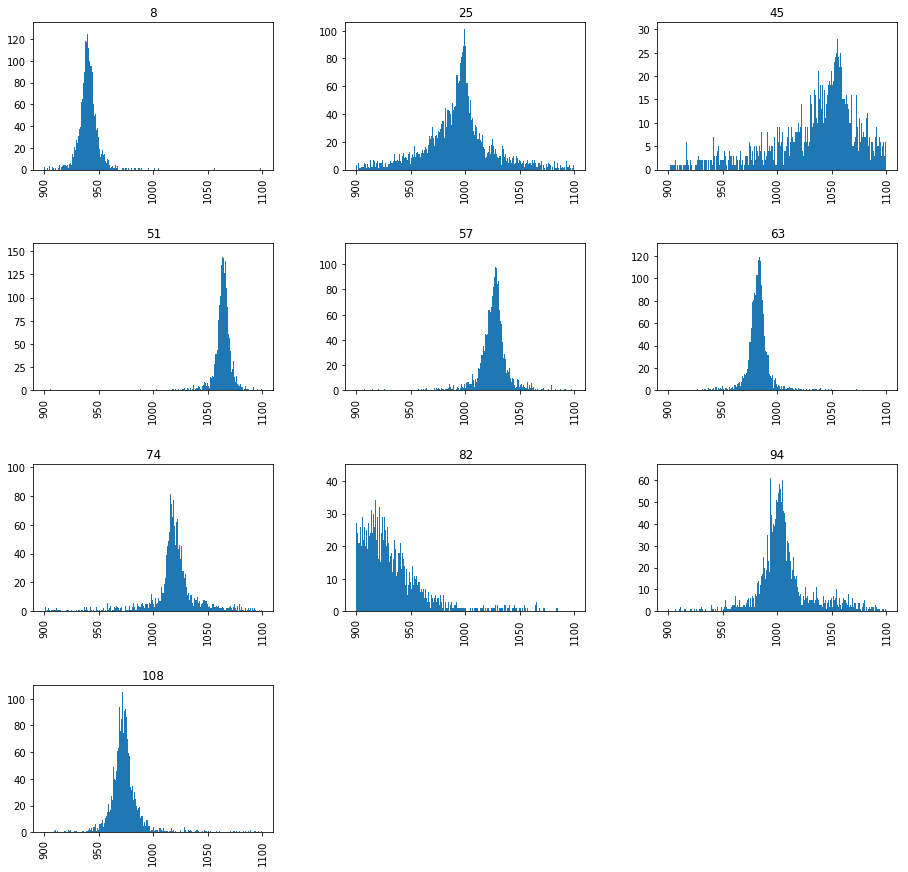

In [213]:
clinic_steps_watch_sit = clinic_steps_watch_acc_df[['user_id', 'acc_norm']]\
                           [clinic_steps_watch_acc_df.step_name=='Sit relaxed']
clinic_steps_watch_sit['acc_norm'].hist(by=clinic_steps_watch_sit['user_id'], figsize=(15,15),
                                           bins=700, range=(900, 1100))

In [152]:
home_steps_watch_acc_df.sort_values(by='timestamp', ascending=True, inplace=True)
home_steps_watch_acc_df.head()

,user_id,assessment_id,assessment_start,assessment_end,timestamp,step_name,x,y,z,patient_report_value,acc_norm,acc_abs_delta
1626789,57,1481922321090,2016-12-16 21:01:38.882,2016-12-16 21:05:21.081,2016-12-16 21:02:05.017,Sit relaxed,-37.0,-269.0,-1010.0,2.0,1045.863280,45.863280
1626790,57,1481922321090,2016-12-16 21:01:38.882,2016-12-16 21:05:21.081,2016-12-16 21:02:05.037,Sit relaxed,-7.0,-289.0,-1006.0,2.0,1046.711995,46.711995
1626791,57,1481922321090,2016-12-16 21:01:38.882,2016-12-16 21:05:21.081,2016-12-16 21:02:05.057,Sit relaxed,-36.0,-246.0,-995.0,2.0,1025.591049,25.591049
1626792,57,1481922321090,2016-12-16 21:01:38.882,2016-12-16 21:05:21.081,2016-12-16 21:02:05.077,Sit relaxed,-2.0,-241.0,-999.0,2.0,1027.660450,27.660450
1626793,57,1481922321090,2016-12-16 21:01:38.882,2016-12-16 21:05:21.081,2016-12-16 21:02:05.097,Sit relaxed,-18.0,-240.0,-997.0,2.0,1025.637850,25.637850


In [153]:
home_steps_watch_mean_norm = home_steps_watch_acc_df[['user_id', 'timestamp', 'assessment_id', 'step_name', 'acc_norm']]\
                             [home_steps_watch_acc_df.step_name=='Sit relaxed']\
                             .groupby(['user_id', 'assessment_id', 'step_name'], as_index=False).agg('mean')

Patient: 8


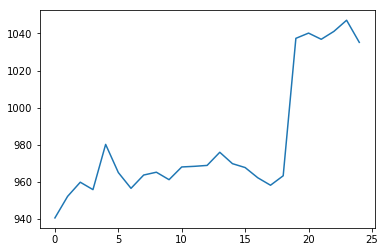

Patient: 25


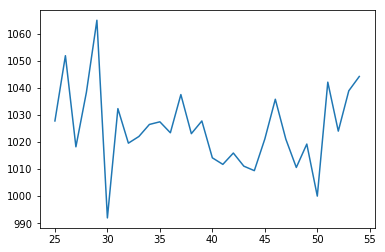

Patient: 45


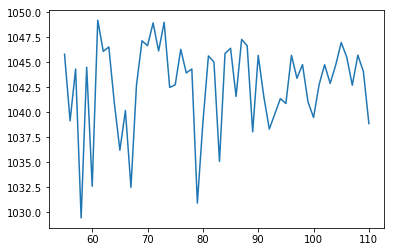

Patient: 51


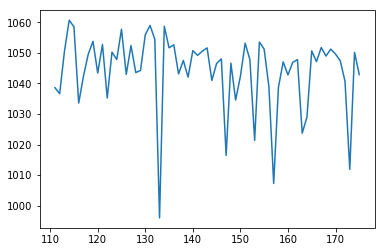

Patient: 57


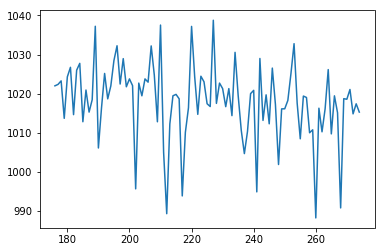

Patient: 63


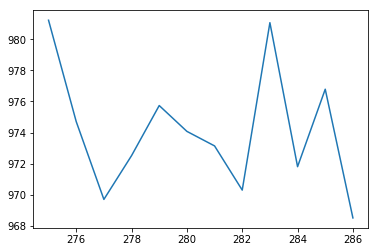

Patient: 74


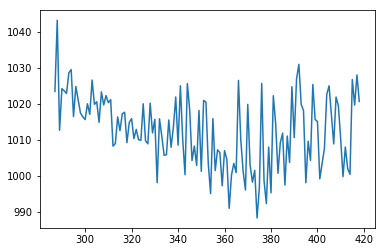

Patient: 82


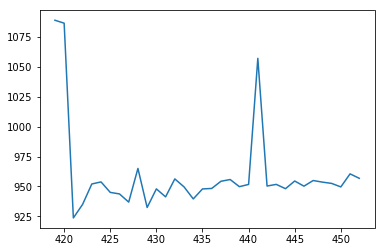

Patient: 94


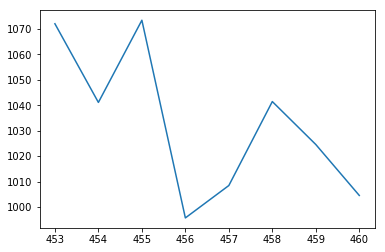

Patient: 108


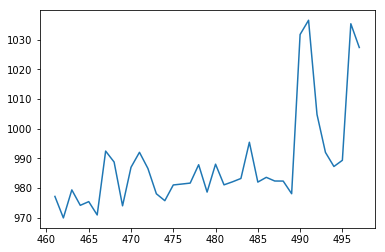

In [154]:
for u in home_steps_watch_mean_norm.user_id.unique():
    print('Patient: %s' % (u))
    plt.plot(home_steps_watch_mean_norm['acc_norm'][home_steps_watch_mean_norm.user_id==u])
    plt.show()
    plt.close()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000253DF4D0898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000253E18F3E80>]], dtype=object)

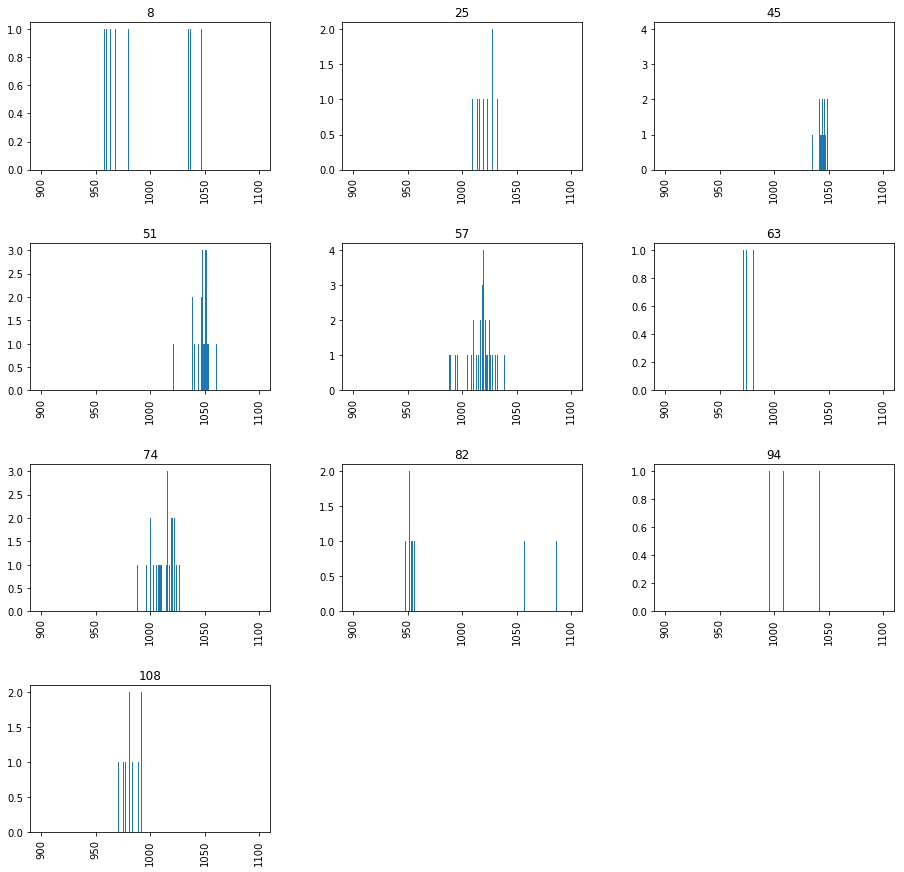

In [148]:
home_steps_watch_mean_norm['acc_norm'].hist(by=home_steps_watch_mean_norm['user_id'], figsize=(15,15),
                                           bins=1000, range=(900, 1100))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000253A39723C8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000253A745AE10>]], dtype=object)

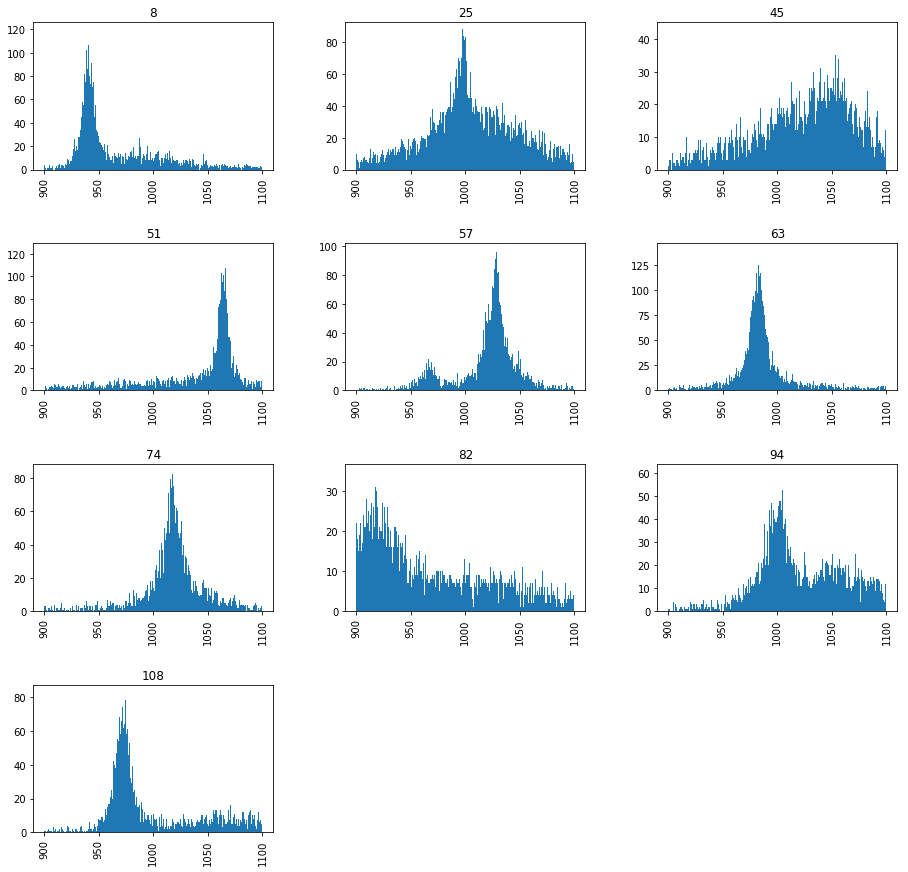

In [132]:
clinic_steps_watch_acc_df['acc_norm'].hist(by=clinic_steps_watch_acc_df['user_id'], figsize=(15,15),
                                           bins=1000, range=(900, 1100))

In [109]:
import os

In [117]:
os.chdir('C:\\Users\\imazeh\\Itzik\\Health_prof\\git_team\\DataScientists')
from Utils.Visualization import box_plot

In [116]:
mean_acc_df = clinic_steps_watch_acc_df[['assessment_id', 'acc_abs_delta', 'patient_report_value']].\
              groupby('assessment_id', as_index=False).agg('mean')

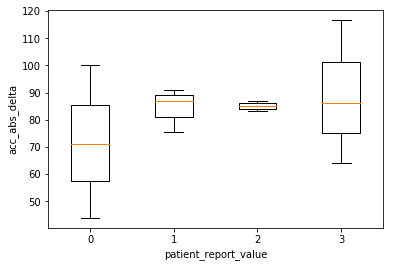

In [139]:
box_plot.create_box_plot(mean_acc_df, 'patient_report_value', 'acc_abs_delta')

In [91]:
def mean_acc_box_plot(df, report_column, variable_column, group_by='assessment_id'):
    mean_acc_df = df[[group_by, variable_column, report_column]]\
                    .groupby(group_by, as_index=False).agg('mean')
    discrete_report_values = c.report_values
    boxes_vals = [np.asarray(mean_acc_df[variable_column][mean_acc_df[report_column] == x]) for x in discrete_report_values]
    plt.boxplot(boxes_vals)
    plt.xticks(range(min_val+1, max_val+2), c.report_values)
#     plt.ylim((920, 1100))
    plt.xlabel('Reported Chorea')
    plt.ylabel("Norm's mean delta from baseline")
    plt.title("%s on %s" % (report_column, df.name))
    plt.show()

### Accelerometer norm mean vs. reported Chorea - clinic patients' reports:

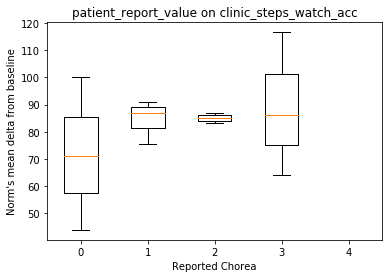

In [92]:
mean_acc_box_plot(clinic_steps_watch_acc_df, 'patient_report_value', 'acc_abs_delta', group_by='assessment_id')

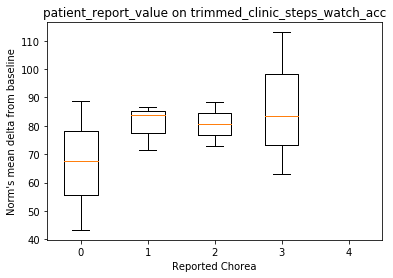

In [93]:
mean_acc_box_plot(trimmed_clinic_steps_watch_acc, 'patient_report_value', 'acc_abs_delta', group_by='assessment_id')

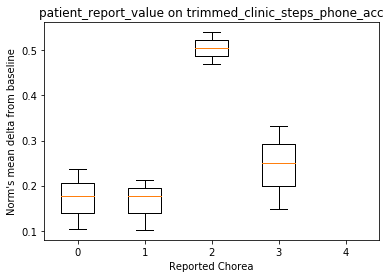

In [94]:
mean_acc_box_plot(trimmed_clinic_steps_phone_acc, 'patient_report_value', 'acc_abs_delta', group_by='assessment_id')

### Accelerometer norm mean vs. reported Chorea - clinic clinicians' reports:

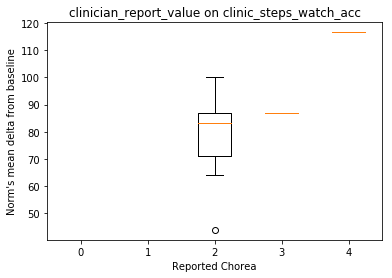

In [95]:
mean_acc_box_plot(clinic_steps_watch_acc_df, 'clinician_report_value', 'acc_abs_delta', group_by='assessment_id')

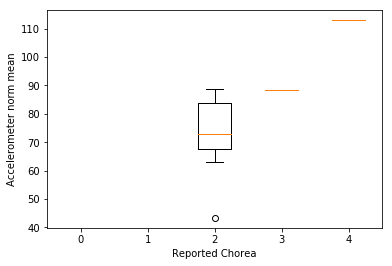

In [67]:
mean_acc_box_plot(trimmed_clinic_steps_watch_acc, 'clinician_report_value', 'acc_abs_delta', group_by='assessment_id')

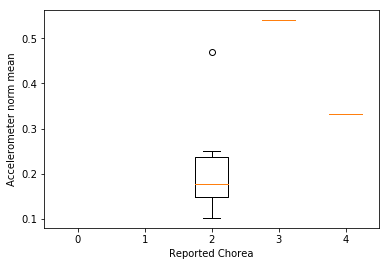

In [68]:
mean_acc_box_plot(trimmed_clinic_steps_phone_acc, 'clinician_report_value', 'acc_abs_delta', group_by='assessment_id')

### Accelerometer norm mean vs. reported Chorea - home patients' reports:

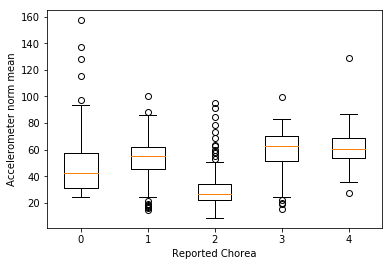

In [75]:
mean_acc_box_plot(home_steps_watch_acc_df, 'patient_report_value', 'acc_abs_delta', group_by='assessment_id')

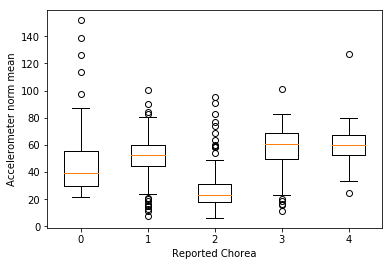

In [76]:
mean_acc_box_plot(trimmed_home_steps_watch_acc, 'patient_report_value', 'acc_abs_delta', group_by='assessment_id')

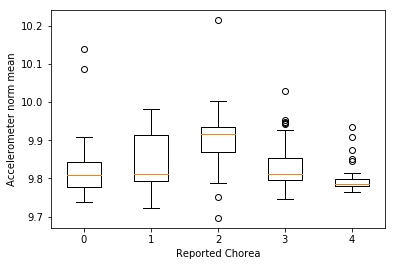

In [71]:
mean_acc_box_plot(home_steps_phone_acc_df, 'patient_report_value', 'acc_norm', group_by='assessment_id')

### Accelerometer norm mean vs. reported Chorea - reminders patients' reports:

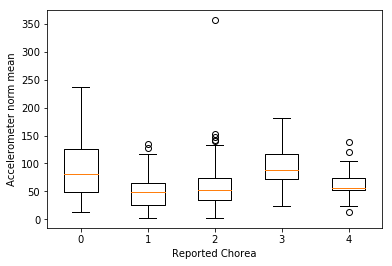

In [14]:
mean_acc_box_plot(home_reminders_watch_acc_df, 'patient_report_value', 'acc_abs_delta', group_by='reminder_id')

## Accelerometer data values per step_name:

In [15]:
clinic_step_agg = clinic_steps_watch_acc_df[['step_name', 'acc_abs_delta']].groupby('step_name', as_index=False).agg('mean')
clinic_step_agg.sort_values(by='acc_abs_delta', inplace=True)
clinic_step_agg

,step_name,acc_abs_delta
3,Sit relaxed,52.509823
2,Sit extended,60.307449
4,Stand,71.647589
0,Drink,83.985035
5,TUaG,102.057856
6,Walk,140.883266
1,Rotate hands,202.597351


In [86]:
clinic_step_agg = trimmed_clinic_steps_watch_acc[['step_name', 'acc_abs_delta']].groupby('step_name', as_index=False).agg('mean')
clinic_step_agg.sort_values(by='acc_abs_delta', inplace=True)
clinic_step_agg

,step_name,acc_abs_delta
3,Sit relaxed,51.552488
2,Sit extended,59.143095
4,Stand,68.222787
0,Drink,83.327396
5,TUaG,100.538979
6,Walk,145.559612
1,Rotate hands,203.342133


In [16]:
clinic_step_agg = clinic_steps_phone_acc_df[['step_name', 'acc_abs_delta']].groupby('step_name', as_index=False).agg('mean')
clinic_step_agg.sort_values(by='acc_abs_delta', inplace=True)
clinic_step_agg

,step_name,acc_abs_delta
2,Sit extended,0.118983
0,Drink,0.144845
1,Rotate hands,0.174296
3,Sit relaxed,0.179817
4,Stand,0.357568
5,TUaG,0.569343
6,Walk,0.924706


In [33]:
home_step_agg = home_steps_watch_acc_df[['step_name', 'acc_abs_delta']].groupby('step_name', as_index=False).agg('mean')
home_step_agg.sort_values(by='acc_abs_delta', inplace=True)
home_step_agg

,step_name,acc_abs_delta
0,Sit relaxed,40.661383
1,Stand,54.612115


In [17]:
home_step_agg = home_steps_phone_acc_df[['step_name', 'acc_abs_delta']].groupby('step_name', as_index=False).agg('mean')
home_step_agg.sort_values(by='acc_abs_delta', inplace=True)
home_step_agg

,step_name,acc_abs_delta
0,Sit relaxed,0.131270
1,Stand,0.259267


In [41]:
clinic_steps_df.step_name.unique()

array(['Sit relaxed', 'TUaG', 'Sit extended', 'Rotate hands', 'Stand',
       'Drink', 'Walk'], dtype=object)

In [191]:
static_steps_clinic = ['Sit extended', 'Sit relaxed', 'Stand']
static_steps_home = ['Sit relaxed', 'Stand']

## Clinic steps - acc delta from user's baseline, with and without trim - PATIENTS REPORTS:

-----------------------------------------------------------------------------------------
Step: Sit extended in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.158


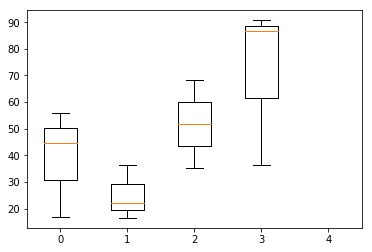

Step: Sit relaxed in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.195


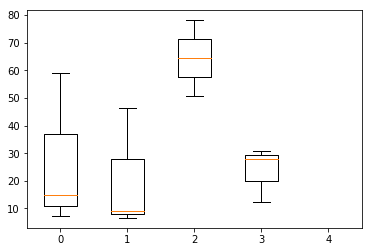

Step: Stand in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.885


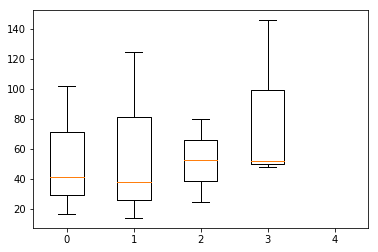

-----------------------------------------------------------------------------------------
Step: Sit extended in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.152


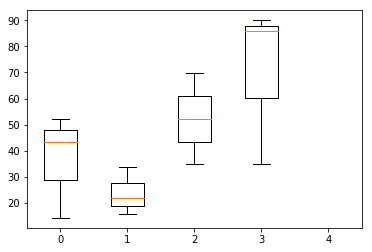

Step: Sit relaxed in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.195


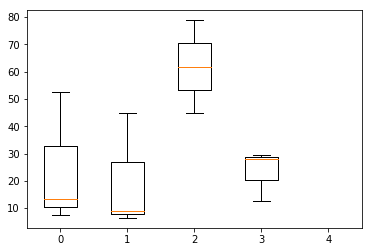

Step: Stand in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.783


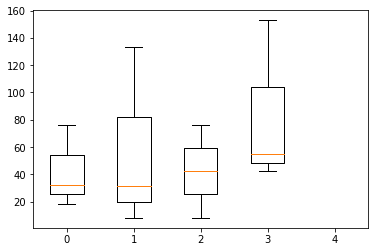

In [209]:
for df in [clinic_steps_watch_acc_w_base, trimmed_clinic_steps_watch_acc_w_base]:
    print('-----------------------------------------------------------------------------------------')
    for step in static_steps_clinic:
        step_df = df[df['step_name']==step]
        agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta_user_bl', 'patient_report_value']]\
              .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
        boxes_vals = [np.asarray(agg['acc_abs_delta_user_bl'][agg['patient_report_value'] == x]) for x in discrete_report_values]
        f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2], boxes_vals[3])
        print('Step: %s in %s' % (step, df.name))
        print('p-value of ANOVA: %.3f' % (p))
        plt.boxplot(boxes_vals)
        plt.xticks(range(min_val+1, max_val+2), range(5))
        plt.show()
        plt.close()

## Clinic steps - acc delta from user's baseline, with and without trim - CLINICIANS REPORTS:

----------------------------------------------------------------------
Step: Sit extended in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.155


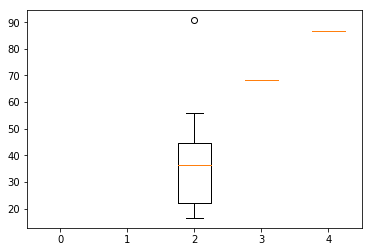

Step: Sit relaxed in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.119


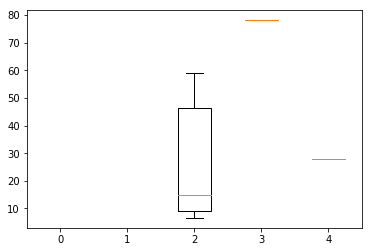

Step: Stand in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.112


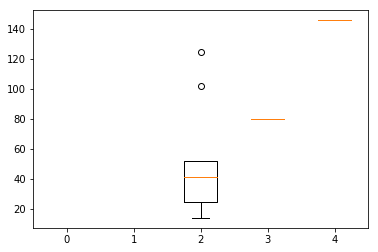

----------------------------------------------------------------------
Step: Sit extended in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.139


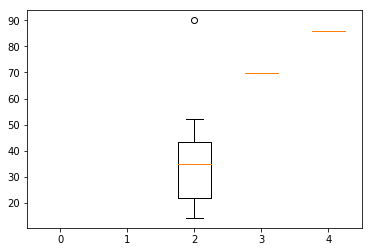

Step: Sit relaxed in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.068


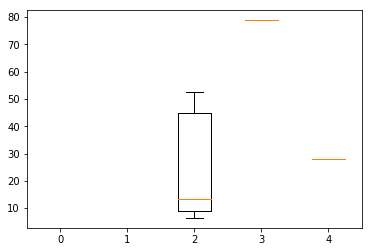

Step: Stand in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.082


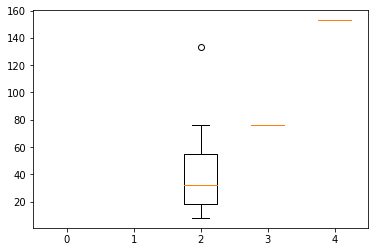

In [202]:
for df in [clinic_steps_watch_acc_w_base, trimmed_clinic_steps_watch_acc_w_base]:
    print('-----------------------------------------------------------------------------------------')
    for step in static_steps_clinic:
        step_df = df[df['step_name']==step]
        agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta_user_bl', 'clinician_report_value']]\
              .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
        boxes_vals = [np.asarray(agg['acc_abs_delta_user_bl'][agg['clinician_report_value'] == x]) for x in discrete_report_values]
        f, p = stats.f_oneway(boxes_vals[2], boxes_vals[3], boxes_vals[4])
        print('Step: %s in %s' % (step, df.name))
        print('p-value of ANOVA: %.3f' % (p))
        plt.boxplot(boxes_vals)
        plt.xticks(range(min_val+1, max_val+2), range(5))
        plt.show()
        plt.close()

## Clinic steps - acc delta from general baseline, with and without trim:

-----------------------------------------------------------------------------------------
Step: Sit extended in clinic_steps_watch_acc
p-value of ANOVA: 0.354


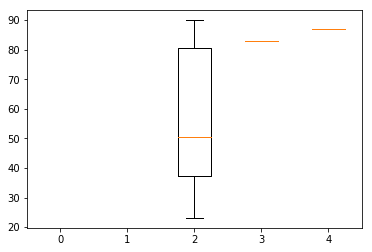

Step: Sit relaxed in clinic_steps_watch_acc
p-value of ANOVA: 0.031


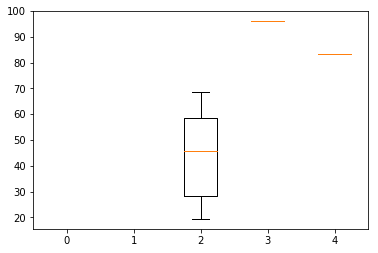

Step: Stand in clinic_steps_watch_acc
p-value of ANOVA: 0.141


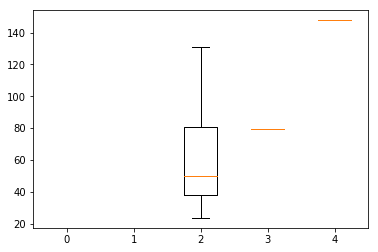

-----------------------------------------------------------------------------------------
Step: Sit extended in trimmed_clinic_steps_watch_acc
p-value of ANOVA: 0.323


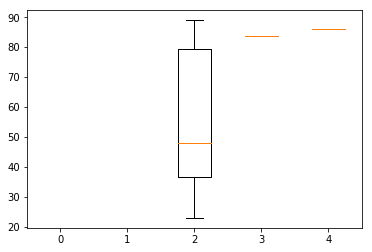

Step: Sit relaxed in trimmed_clinic_steps_watch_acc
p-value of ANOVA: 0.020


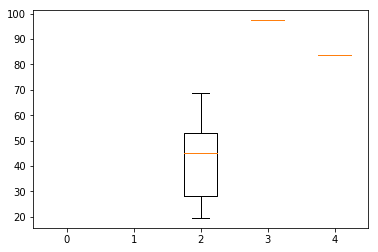

Step: Stand in trimmed_clinic_steps_watch_acc
p-value of ANOVA: 0.112


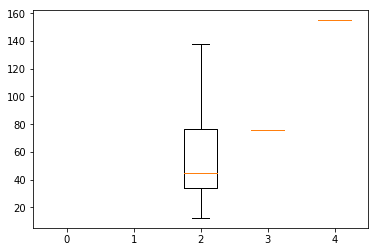

In [204]:
for df in [clinic_steps_watch_acc_df, trimmed_clinic_steps_watch_acc]:
    print('-----------------------------------------------------------------------------------------')
    for step in static_steps_clinic:
        step_df = df[df['step_name']==step]
        agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta', 'clinician_report_value']]\
              .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
        boxes_vals = [np.asarray(agg['acc_abs_delta'][agg['clinician_report_value'] == x]) for x in discrete_report_values]
        f, p = stats.f_oneway(boxes_vals[2], boxes_vals[3], boxes_vals[4])
        print('Step: %s in %s' % (step, df.name))
        print('p-value of ANOVA: %.3f' % (p))
        plt.boxplot(boxes_vals)
        plt.xticks(range(min_val+1, max_val+2), range(5))
        plt.show()
        plt.close()

## Home steps - acc delta from user's baseline, with and without trim:

-----------------------------------------------------------------------------------------
Step: Sit relaxed in home_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.000


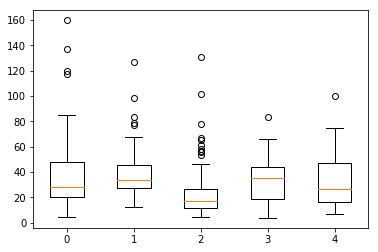

Step: Stand in home_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.000


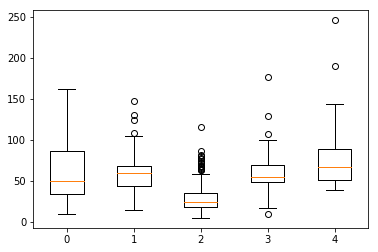

-----------------------------------------------------------------------------------------
Step: Sit relaxed in trimmed_home_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.000


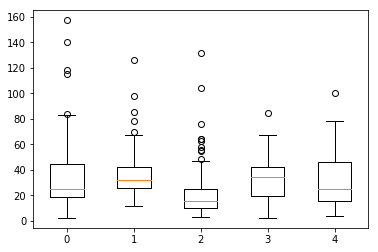

Step: Stand in trimmed_home_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.000


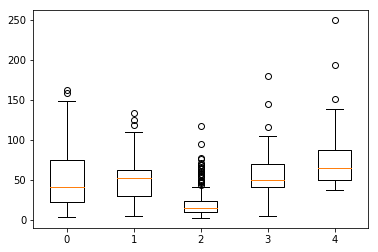

In [205]:
for df in [home_steps_watch_acc_w_base, trimmed_home_steps_watch_acc_w_base]:
    print('-----------------------------------------------------------------------------------------')
    for step in static_steps_home:
        step_df = df[df['step_name']==step]
        agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta_user_bl', 'patient_report_value']]\
              .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
        boxes_vals = [np.asarray(agg['acc_abs_delta_user_bl'][agg['patient_report_value'] == x]) for x in discrete_report_values]
        f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2], boxes_vals[3], boxes_vals[4])
        print('Step: %s in %s' % (step, df.name))
        print('p-value of ANOVA: %.3f' % (p))
        plt.boxplot(boxes_vals)
        plt.xticks(range(min_val+1, max_val+2), range(5))
        plt.show()
        plt.close()

## Home steps - acc delta from general baseline, with and without trim:

-----------------------------------------------------------------------------------------
Step: Sit relaxed in home_steps_watch_acc
p-value of ANOVA: 0.000


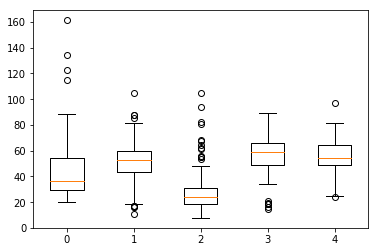

Step: Stand in home_steps_watch_acc
p-value of ANOVA: 0.000


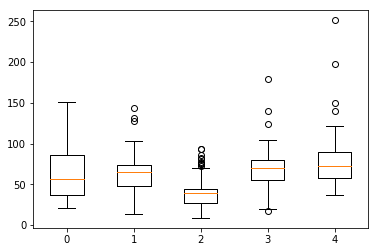

-----------------------------------------------------------------------------------------
Step: Sit relaxed in trimmed_home_steps_watch_acc
p-value of ANOVA: 0.000


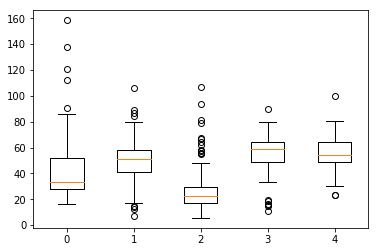

Step: Stand in trimmed_home_steps_watch_acc
p-value of ANOVA: 0.000


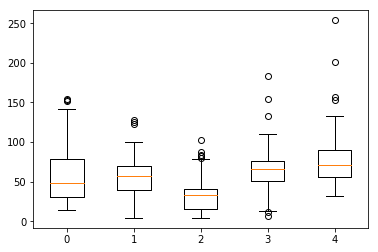

In [206]:
for df in [home_steps_watch_acc_df, trimmed_home_steps_watch_acc]:
    print('-----------------------------------------------------------------------------------------')
    for step in static_steps_home:
        step_df = df[df['step_name']==step]
        agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta', 'patient_report_value']]\
              .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
        boxes_vals = [np.asarray(agg['acc_abs_delta'][agg['patient_report_value'] == x]) for x in discrete_report_values]
        f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2], boxes_vals[3], boxes_vals[4])
        print('Step: %s in %s' % (step, df.name))
        print('p-value of ANOVA: %.3f' % (p))
        plt.boxplot(boxes_vals)
        plt.xticks(range(min_val+1, max_val+2), range(5))
        plt.show()
        plt.close()

## Accelerometer data exploration:

In [18]:
home_steps_watch_acc_df[home_steps_watch_acc_df.patient_report_value==0].head(50)

,user_id,assessment_id,assessment_start,assessment_end,timestamp,step_name,x,y,z,patient_report_value,acc_norm,acc_abs_delta
216,63,1494943400069,2017-05-16 14:00:20.836,2017-05-16 14:03:16.601,2017-05-16 14:00:26.007,Sit relaxed,-180.0,-53.0,-973.0,0.0,990.927848,9.072152
217,63,1494943400069,2017-05-16 14:00:20.836,2017-05-16 14:03:16.601,2017-05-16 14:00:26.027,Sit relaxed,-247.0,-71.0,-978.0,0.0,1011.204233,11.204233
218,63,1494943400069,2017-05-16 14:00:20.836,2017-05-16 14:03:16.601,2017-05-16 14:00:26.047,Sit relaxed,-254.0,-52.0,-1005.0,0.0,1037.904138,37.904138
219,63,1494943400069,2017-05-16 14:00:20.836,2017-05-16 14:03:16.601,2017-05-16 14:00:26.067,Sit relaxed,-209.0,-31.0,-993.0,0.0,1015.229531,15.229531
220,63,1494943400069,2017-05-16 14:00:20.836,2017-05-16 14:03:16.601,2017-05-16 14:00:26.095,Sit relaxed,-57.0,-340.0,-967.0,0.0,1026.614826,26.614826
221,63,1494943400069,2017-05-16 14:00:20.836,2017-05-16 14:03:16.601,2017-05-16 14:00:26.115,Sit relaxed,-212.0,-69.0,-975.0,0.0,1000.164986,0.164986
222,63,1494943400069,2017-05-16 14:00:20.836,2017-05-16 14:03:16.601,2017-05-16 14:00:26.135,Sit relaxed,-174.0,-70.0,-949.0,0.0,967.355674,32.644326
223,63,1494943400069,2017-05-16 14:00:20.836,2017-05-16 14:03:16.601,2017-05-16 14:00:26.155,Sit relaxed,-153.0,-65.0,-938.0,0.0,952.616397,47.383603
224,63,1494943400069,2017-05-16 14:00:20.836,2017-05-16 14:03:16.601,2017-05-16 14:00:26.175,Sit relaxed,-138.0,-58.0,-886.0,0.0,898.556620,101.443380
225,63,1494943400069,2017-05-16 14:00:20.836,2017-05-16 14:03:16.601,2017-05-16 14:00:26.195,Sit relaxed,-111.0,-137.0,-888.0,0.0,905.336402,94.663598


In [67]:
home_assess_reported_0 = 1494943400069
home_assess_reported_2 = 1487729046375

In [68]:
watch_level_0_sit = home_steps_watch_acc_df[['x', 'y', 'z']][(home_steps_watch_acc_df.assessment_id==home_assess_reported_0)\
                                                      &(home_steps_watch_acc_df.step_name=='Sit relaxed')]
watch_level_0_stand = home_steps_watch_acc_df[['x', 'y', 'z']][(home_steps_watch_acc_df.assessment_id==home_assess_reported_0)\
                                                        &(home_steps_watch_acc_df.step_name=='Stand')]

In [66]:
watch_level_2_sit = home_steps_watch_acc_df[['x', 'y', 'z']][(home_steps_watch_acc_df.assessment_id==home_assess_reported_2)\
                                                      &(home_steps_watch_acc_df.step_name=='Sit relaxed')]
watch_level_2_stand = home_steps_watch_acc_df[['x', 'y', 'z']][(home_steps_watch_acc_df.assessment_id==home_assess_reported_2)\
                                                        &(home_steps_watch_acc_df.step_name=='Stand')]

NameError: name 'home_assess_reported_2' is not defined

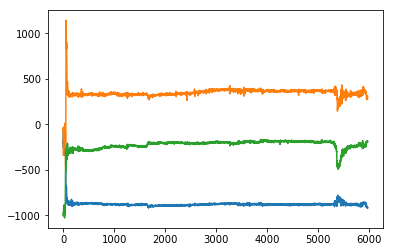

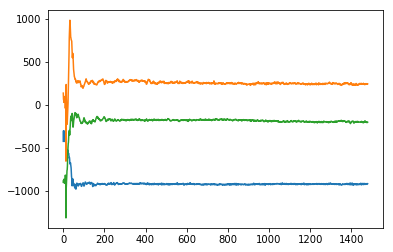

In [27]:
plt.plot(np.asarray(watch_level_0_sit))
plt.show()
plt.plot(np.asarray(watch_level_0_stand))
plt.show()

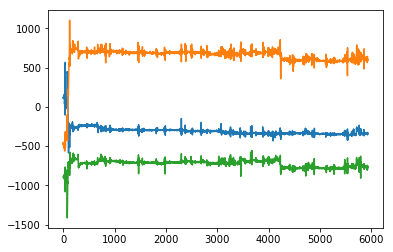

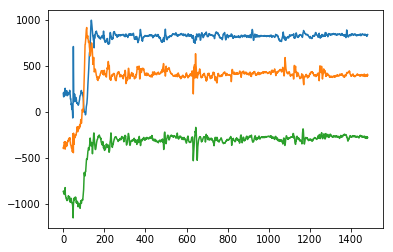

In [28]:
plt.plot(np.asarray(watch_level_2_sit))
plt.show()
plt.plot(np.asarray(watch_level_2_stand))
plt.show()

In [31]:
phone_level_0_sit = home_steps_phone_acc_df[['x', 'y', 'z']][(home_steps_phone_acc_df.assessment_id==home_assess_reported_0)\
                                                      &(home_steps_phone_acc_df.step_name=='Sit relaxed')]
phone_level_0_stand = home_steps_phone_acc_df[['x', 'y', 'z']][(home_steps_phone_acc_df.assessment_id==home_assess_reported_0)\
                                                        &(home_steps_phone_acc_df.step_name=='Stand')]

In [29]:
phone_level_2_sit = home_steps_phone_acc_df[['x', 'y', 'z']][(home_steps_phone_acc_df.assessment_id==home_assess_reported_2)\
                                                      &(home_steps_phone_acc_df.step_name=='Sit relaxed')]
phone_level_2_stand = home_steps_phone_acc_df[['x', 'y', 'z']][(home_steps_phone_acc_df.assessment_id==home_assess_reported_2)\
                                                        &(home_steps_phone_acc_df.step_name=='Stand')]

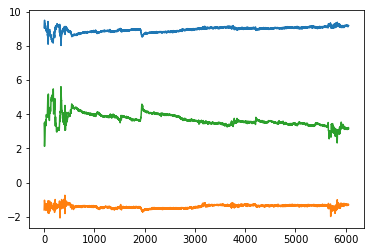

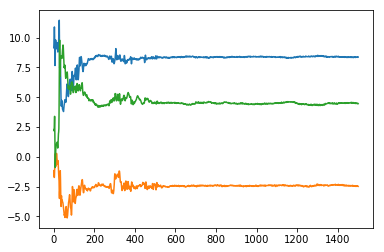

In [32]:
plt.plot(np.asarray(phone_level_0_sit))
plt.show()
plt.plot(np.asarray(phone_level_0_stand))
plt.show()

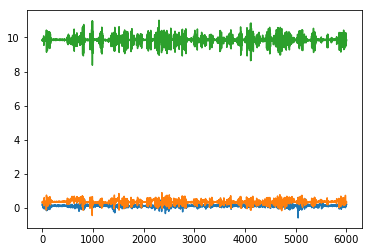

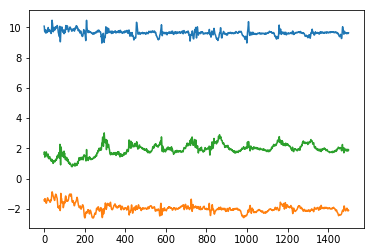

In [33]:
plt.plot(np.asarray(phone_level_2_sit))
plt.show()
plt.plot(np.asarray(phone_level_2_stand))
plt.show()

## Clinic Raw Data Exploration:

In [13]:
clinic_steps_watch_acc_df.head()

,user_id,assessment_id,assessment_start,assessment_end,timestamp,step_name,x,y,z,patient_report_value,clinician_report_value,acc_norm,acc_abs_delta
0,82,1489765988342,2017-03-17 15:43:54.743,2017-03-17 15:53:08.333,2017-03-17 15:45:59.730,Sit relaxed,-925.0,49.0,-158.0,3.0,4.0,939.675476,60.324524
1,82,1489765988342,2017-03-17 15:43:54.743,2017-03-17 15:53:08.333,2017-03-17 15:45:59.750,Sit relaxed,-934.0,17.0,-163.0,3.0,4.0,948.268949,51.731051
2,82,1489765988342,2017-03-17 15:43:54.743,2017-03-17 15:53:08.333,2017-03-17 15:45:59.770,Sit relaxed,-931.0,-5.0,-150.0,3.0,4.0,943.019618,56.980382
3,82,1489765988342,2017-03-17 15:43:54.743,2017-03-17 15:53:08.333,2017-03-17 15:45:59.798,Sit relaxed,-916.0,5.0,-144.0,3.0,4.0,927.263177,72.736823
4,82,1489765988342,2017-03-17 15:43:54.743,2017-03-17 15:53:08.333,2017-03-17 15:45:59.818,Sit relaxed,-924.0,20.0,-151.0,3.0,4.0,936.470501,63.529499


In [37]:
clinic_watch = clinic_steps_watch_acc_df[['user_id', 'assessment_id', 'timestamp', 'patient_report_value',
                                          'clinician_report_value']].sort_values(by=['user_id', 'assessment_id', 'timestamp'])
clinic_watch = clinic_watch[['user_id', 'assessment_id', 'patient_report_value', 'clinician_report_value']]

In [38]:
clinic_watch.drop_duplicates().head()

,user_id,assessment_id,patient_report_value,clinician_report_value
32657,8,1490640580656,1.0,2.0
134261,25,1487605701264,1.0,2.0
87102,25,1493912424448,0.0,2.0
31321,45,1490637319938,2.0,3.0
123861,51,1490284781631,3.0,2.0





patient: 8.0, assessment: 1.49064058066e+12
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 37.966


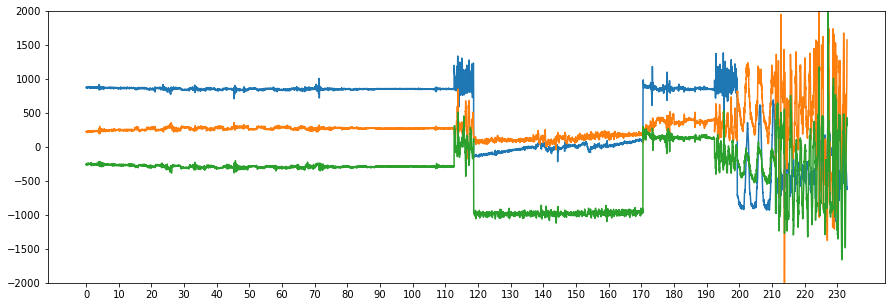




patient: 25.0, assessment: 1.48760570126e+12
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 80.649


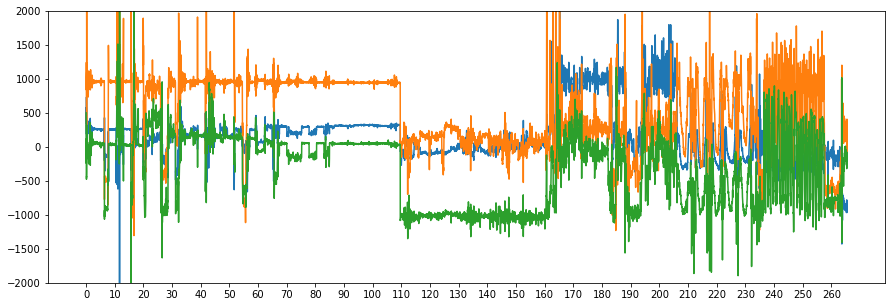




patient: 25.0, assessment: 1.49391242445e+12
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 84.357


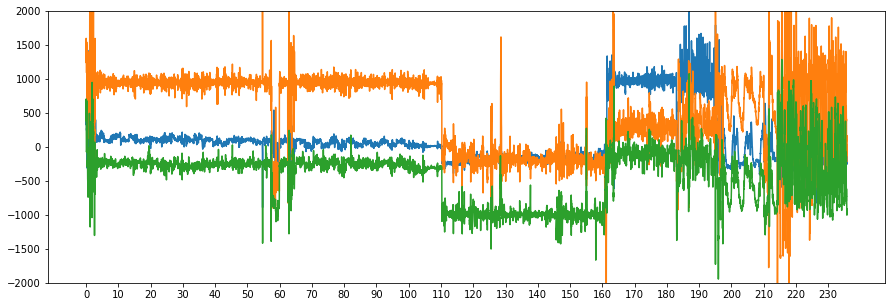




patient: 45.0, assessment: 1.49063731994e+12
patient report: 2, clinician report: 3
Norm's mean delta from baseline: 76.677


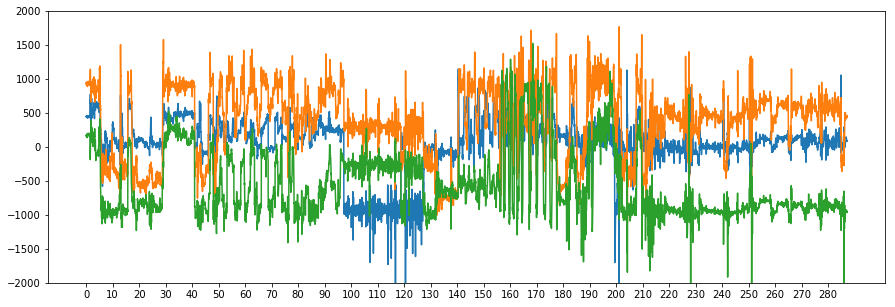




patient: 51.0, assessment: 1.49028478163e+12
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 53.665


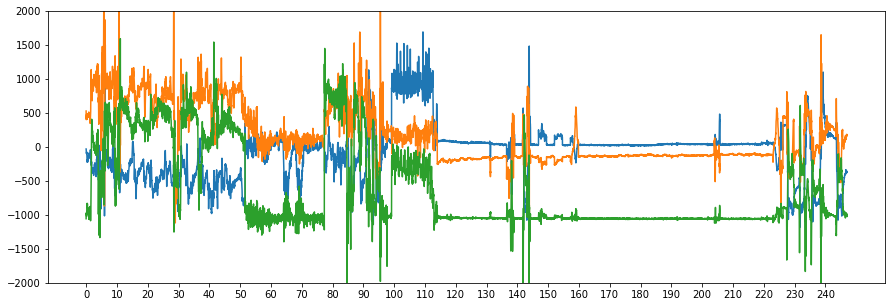




patient: 57.0, assessment: 1.48192323299e+12
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 62.435


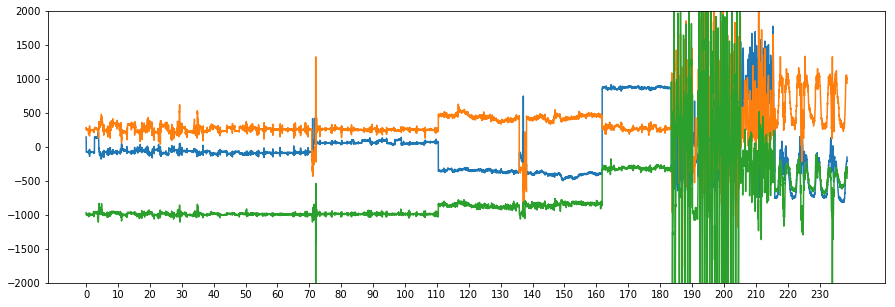




patient: 63.0, assessment: 1.49392065212e+12
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 34.809


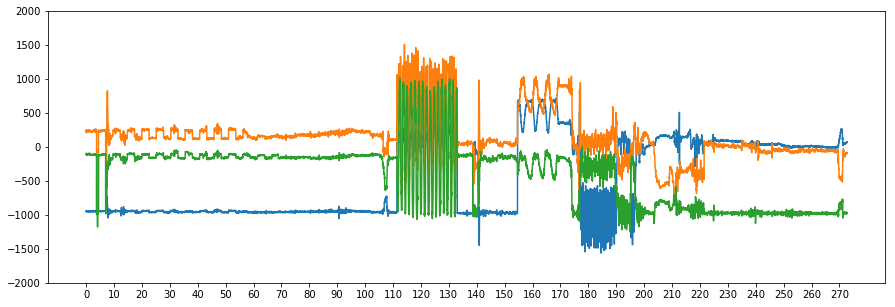




patient: 74.0, assessment: 1.48554632115e+12
patient report: 2, clinician report: 2
Norm's mean delta from baseline: 68.075


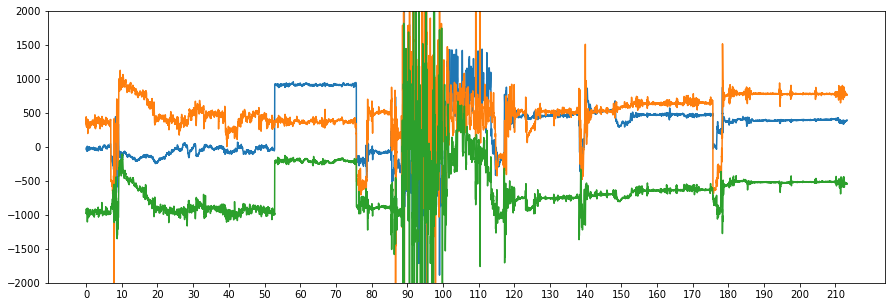




patient: 82.0, assessment: 1.48976598834e+12
patient report: 3, clinician report: 4
Norm's mean delta from baseline: 86.132


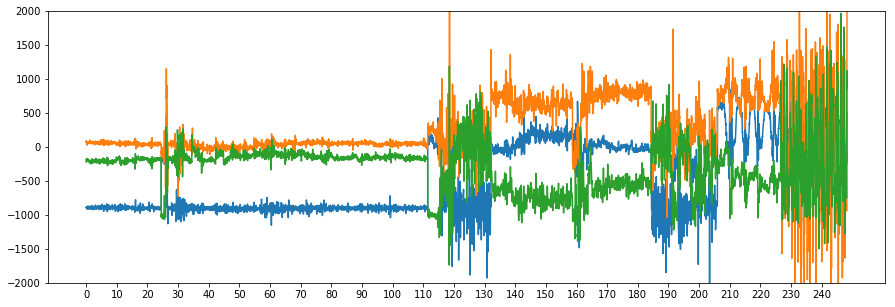




patient: 94.0, assessment: 1.49374195704e+12
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 50.695


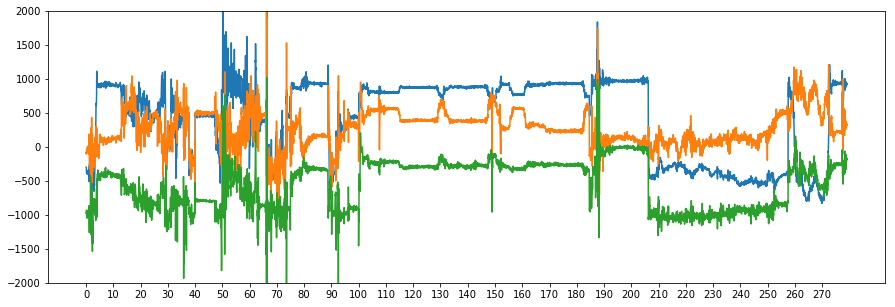




patient: 108.0, assessment: 1.48839618164e+12
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 45.633


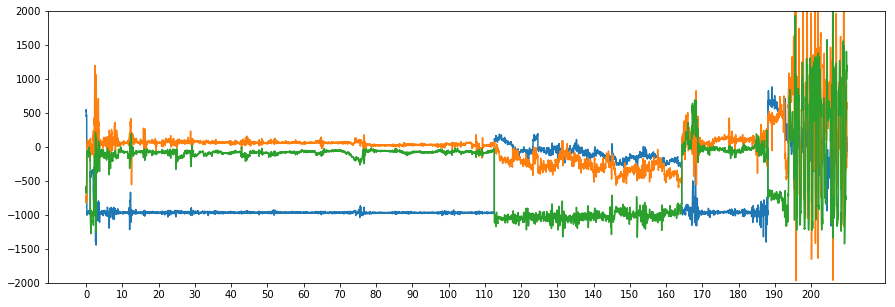

In [46]:
for index, row in clinic_watch.drop_duplicates().iterrows():
    user_id = row['user_id']
    assessment_id = row['assessment_id']
#     step_name = row['step_name']
    patient_report_value = row['patient_report_value']
    clinician_report_value = row['clinician_report_value']
    
    print('\n\n')
    print('patient: %s, assessment: %s' % (user_id, str(assessment_id)))
    print('patient report: %.0f, clinician report: %.0f' % (patient_report_value, clinician_report_value))
    norm_values = trimmed_clinic_steps_watch_acc_w_base[['assessment_id', 'acc_abs_delta_user_bl']]\
                  [trimmed_clinic_steps_watch_acc_w_base['assessment_id']==assessment_id]
    norm = np.mean(norm_values['acc_abs_delta_user_bl'])
    print("Norm's mean delta from baseline: %.3f" % (norm))
    signal = trimmed_clinic_steps_watch_acc_w_base[['x', 'y', 'z']]\
             [trimmed_clinic_steps_watch_acc_w_base.assessment_id==assessment_id]
    signal = np.asarray(signal)
    plt.figure(figsize=(15,5))
    plt.plot(signal)
    plt.ylim(-2000, 2000)
    plt.xticks(range(0, signal.shape[0], 500), range(0, int(signal.shape[0]/50), 10))
    plt.show()
    plt.close()

    
    
    
#     if step_name=='Stand':
    
#         print('\n\n')
#         print('patient: %s, step: %s' % (user_id, step_name))
#         print('patient report: %.0f, clinician report: %.0f' % (patient_report_value, clinician_report_value))
#         norm_values = trimmed_clinic_steps_watch_acc_w_base[['assessment_id', 'step_name', 'acc_abs_delta_user_bl']]\
#                       [(trimmed_clinic_steps_watch_acc_w_base['assessment_id']==assessment_id)
#                       &(trimmed_clinic_steps_watch_acc_w_base['step_name']==step_name)]
#         norm = np.mean(norm_values['acc_abs_delta_user_bl'])
#         print("Norm's mean delta from baseline: %.3f" % (norm))
#         signal = trimmed_clinic_steps_watch_acc_w_base[['x', 'y', 'z']][(trimmed_clinic_steps_watch_acc_w_base.assessment_id==assessment_id)\
#                                                                        &(trimmed_clinic_steps_watch_acc_w_base.step_name==step_name)]
#         signal = np.asarray(signal)
#         plt.figure()
#         plt.plot(signal)
#         plt.ylim(-2000, 2000)
#         plt.xticks(range(0, signal.shape[0], 500), range(0, int(signal.shape[0]/50), 10))
#         plt.show()
#         plt.close()

In [105]:
clinic_phone = clinic_steps_phone_acc_df[['user_id', 'assessment_id', 'step_name', 'patient_report_value', 'clinician_report_value']]\
               .drop_duplicates().sort_values(by=['user_id', 'assessment_id'])




patient: 8, step: Stand
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 0.281


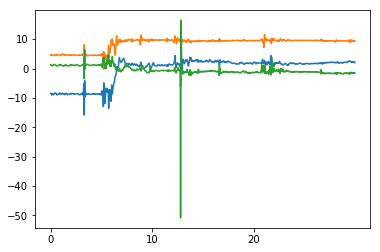




patient: 25, step: Stand
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 0.362


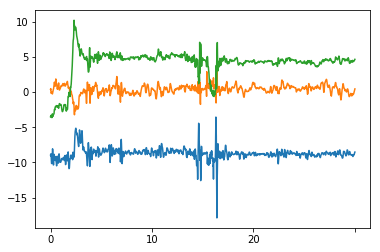




patient: 25, step: Stand
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 0.056


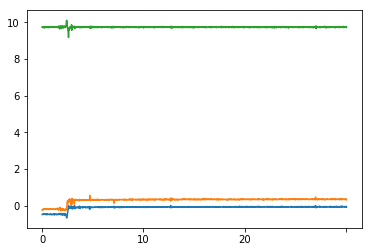




patient: 45, step: Stand
patient report: 2, clinician report: 3
Norm's mean delta from baseline: 0.610


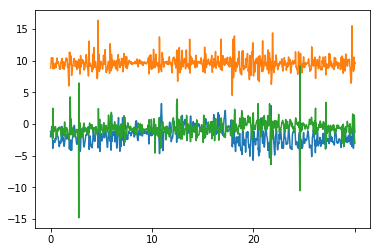




patient: 51, step: Stand
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 0.474


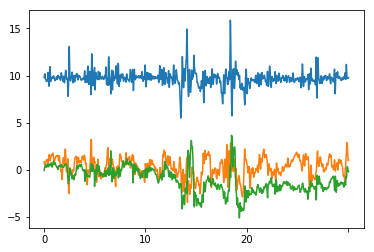




patient: 57, step: Stand
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 0.066


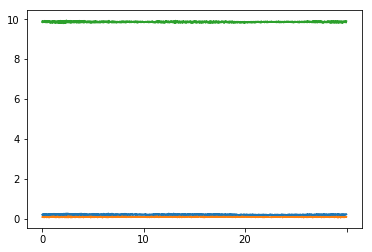




patient: 63, step: Stand
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 0.060


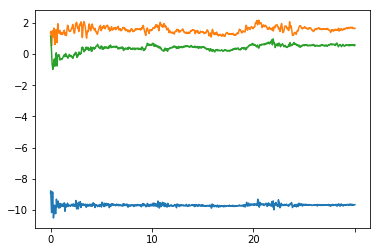




patient: 74, step: Stand
patient report: 2, clinician report: 2
Norm's mean delta from baseline: 0.545


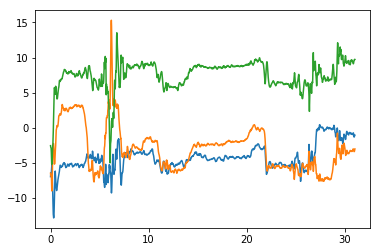




patient: 82, step: Stand
patient report: 3, clinician report: 4
Norm's mean delta from baseline: 1.247


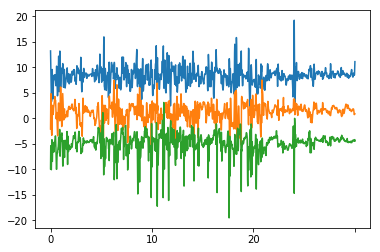




patient: 94, step: Stand
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 0.071


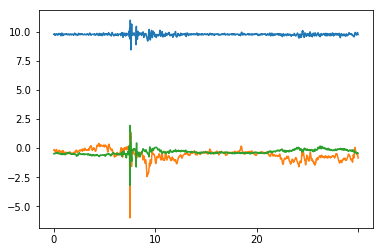




patient: 108, step: Stand
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 0.155


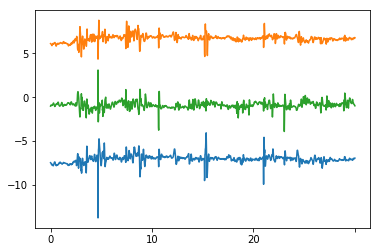

In [108]:
for index, row in clinic_phone.iterrows():
    user_id = row['user_id']
    assessment_id = row['assessment_id']
    step_name = row['step_name']
    patient_report_value = row['patient_report_value']
    clinician_report_value = row['clinician_report_value']

    if step_name=='Stand':
        print('\n\n')
        print('patient: %s, step: %s' % (user_id, step_name))
        print('patient report: %.0f, clinician report: %.0f' % (patient_report_value, clinician_report_value))
        norm_values = clinic_steps_phone_acc_df[['assessment_id', 'step_name', 'acc_abs_delta']]\
                      [(clinic_steps_phone_acc_df['assessment_id']==assessment_id)
                      &(clinic_steps_phone_acc_df['step_name']==step_name)]
        norm = np.mean(norm_values['acc_abs_delta'])
        print("Norm's mean delta from baseline: %.3f" % (norm))
        signal = clinic_steps_phone_acc_df[['x', 'y', 'z']][(clinic_steps_phone_acc_df.assessment_id==assessment_id)\
                                                           &(clinic_steps_phone_acc_df.step_name==step_name)]
        signal = np.asarray(signal)
        plt.figure()
        plt.plot(signal)
    #     plt.ylim(-2000, 2000)
        plt.xticks(range(0, signal.shape[0], 500), range(0, int(signal.shape[0]/50), 10))
        plt.show()
        plt.close()

## Home Raw Data Exploration:

In [8]:
all_home_assessments = home_steps_watch_acc_df.assessment_id.unique().tolist()
home_steps = ['Sit relaxed', 'Stand']




Patient: 51
Patient reported chorea level: 2
Data: home_steps_watch_acc
Step: Sit relaxed
Norm's mean absolute delta: 54.990
len: 5978


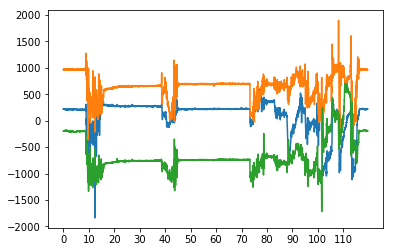

Step: Stand
Norm's mean absolute delta: 68.511
len: 1495


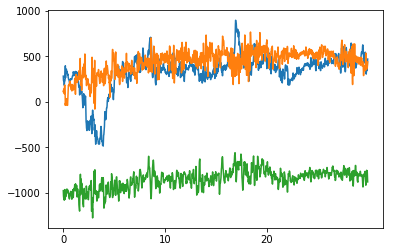

Data: home_steps_phone_acc
Step: Sit relaxed
Norm's mean absolute delta: 0.019
len: 6018


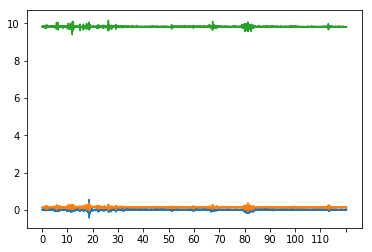

Step: Stand
Norm's mean absolute delta: 0.028
len: 1505


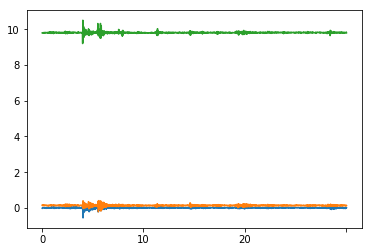




Patient: 57
Patient reported chorea level: 2
Data: home_steps_watch_acc
Step: Sit relaxed
Norm's mean absolute delta: 28.407
len: 5978


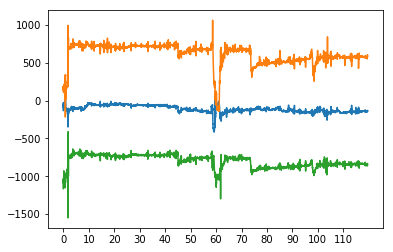

Step: Stand
Norm's mean absolute delta: 40.418
len: 1483


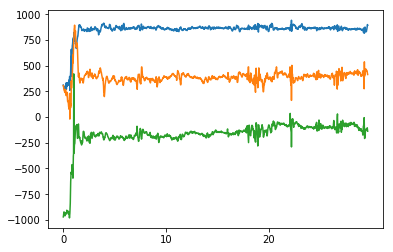

Data: home_steps_phone_acc
Step: Sit relaxed
Norm's mean absolute delta: 0.057
len: 6054


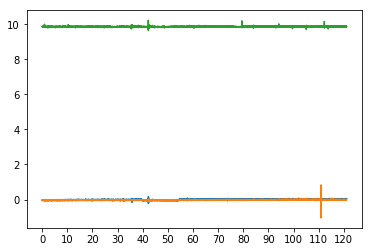

Step: Stand
Norm's mean absolute delta: 0.062
len: 1501


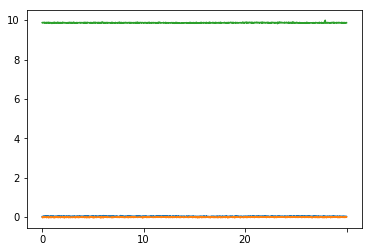




Patient: 51
Patient reported chorea level: 4
Data: home_steps_watch_acc
Step: Sit relaxed
Norm's mean absolute delta: 56.142
len: 6019


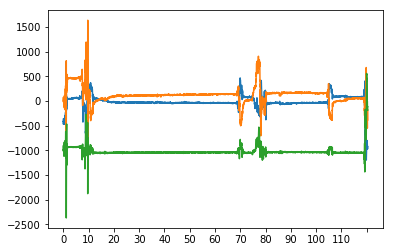

Step: Stand
Norm's mean absolute delta: 121.052
len: 1494


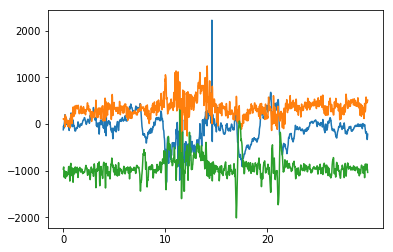

Data: home_steps_phone_acc
Step: Sit relaxed
Norm's mean absolute delta: 0.031
len: 6068


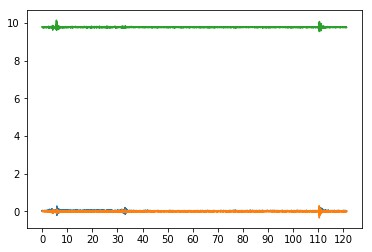

Step: Stand
Norm's mean absolute delta: 0.055
len: 1505


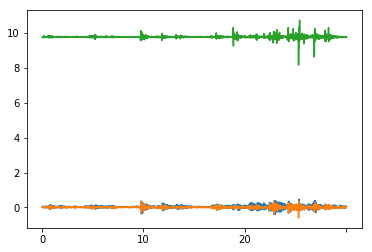




Patient: 45
Patient reported chorea level: 1
Data: home_steps_watch_acc
Step: Sit relaxed
Norm's mean absolute delta: 61.244
len: 5968


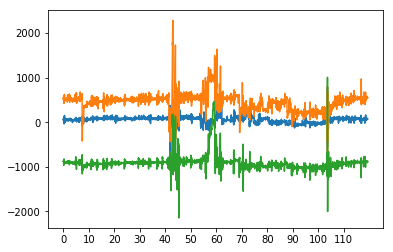

Step: Stand
Norm's mean absolute delta: 72.189
len: 1480


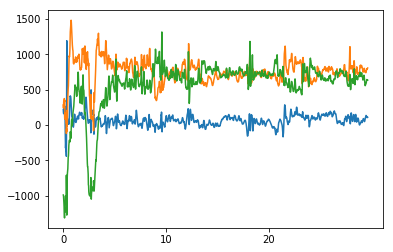

Data: home_steps_phone_acc
Step: Sit relaxed
Norm's mean absolute delta: 0.222
len: 6056


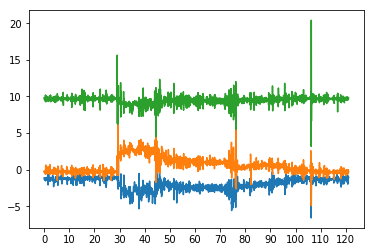

Step: Stand
Norm's mean absolute delta: 0.963
len: 1501


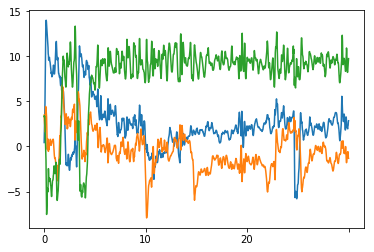




Patient: 57
Patient reported chorea level: 2
Data: home_steps_watch_acc
Step: Sit relaxed
Norm's mean absolute delta: 24.212
len: 5947


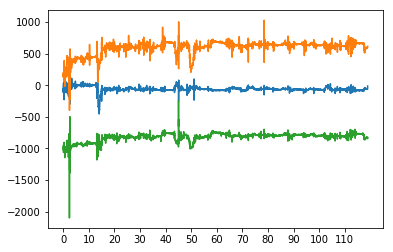

Step: Stand
Norm's mean absolute delta: 42.692
len: 1487


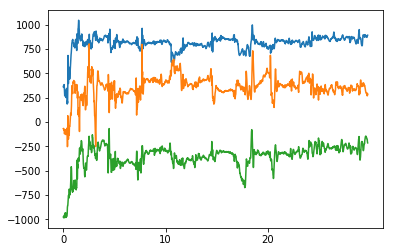

Data: home_steps_phone_acc
Step: Sit relaxed
Norm's mean absolute delta: 0.043
len: 6004


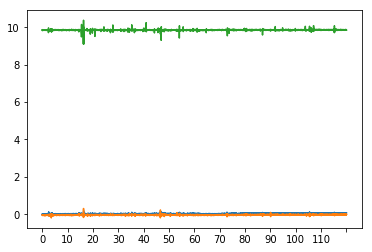

Step: Stand
Norm's mean absolute delta: 0.224
len: 1501


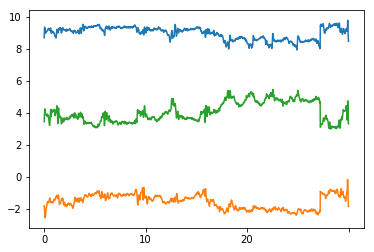

In [16]:
random_assessments = np.random.choice(all_home_assessments, 5, replace = False)
for a in random_assessments:
    single_row = home_steps_watch_acc_df[['user_id', 'assessment_id', 'patient_report_value']]\
                 [home_steps_watch_acc_df.assessment_id==a].drop_duplicates()
    user_id = int(single_row.iloc[0]['user_id'])
    patient_report_value = single_row['patient_report_value']
    print('\n\n')
    print('Patient: %s' % (user_id))
    print('Patient reported chorea level: %.0f' % (patient_report_value))

    for acc_data in [home_steps_watch_acc_df, home_steps_phone_acc_df]:
        print('Data: %s' % (acc_data.name))
        for step in home_steps:
            print('Step: %s' % (step))
            norm_abs_delta = np.mean(acc_data['acc_abs_delta'][(acc_data.assessment_id==a)\
                                                              &(acc_data.step_name==step)])
            print("Norm's mean absolute delta: %.3f" % (norm_abs_delta))
            signal = acc_data[['x', 'y', 'z']][(acc_data.assessment_id==a)\
                                              &(acc_data.step_name==step)]
            signal = np.asarray(signal)
            print('len:', len(signal))
            plt.figure()
            plt.plot(signal)
            plt.xticks(range(0, signal.shape[0], 500), range(0, int(signal.shape[0]/50), 10))

            plt.show()
            plt.close()